# Imports and plot properties


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Feb  6 15:24:06 2020

@author: Shiva
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlt
import pandas as pd
from pandas import read_excel
from matplotlib.font_manager import FontProperties
from scipy.ndimage.interpolation import shift
import os
import glob
import timeit
from scipy import stats
import statsmodels.stats.api as sms
from matplotlib.collections import LineCollection
from tempfile import TemporaryFile
import matplotlib.gridspec as gridspec
# import numpy_indexed as npi
#print(os.path.dirname(__file__))


#############################   Plot properties   ########################################################


font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_style('italic')
font.set_size('30')
font.set_weight('bold')

font_label = FontProperties()
font_label.set_family('serif')
font_label.set_name('Times New Roman')
font_label.set_style('italic')
font_label.set_size('25')
font_label.set_weight('bold')

import matplotlib.font_manager as fm
from matplotlib import ft2font
from matplotlib.font_manager import ttfFontProperty



# fpath = '/home/shiva/Downloads/Times_New_Roman.ttf'
# font_ = ft2font.FT2Font(fpath)
# fprop = FontProperties(fname=fpath)

# ttfFontProp = ttfFontProperty(font_)

# fontprop = fm.FontProperties(family='sans-serif',
#                             #name=ap.fontprop.name,
#                             fname=ttfFontProp.fname,
#                             size=fontsize,
#                             stretch=ttfFontProp.stretch,
#                             style=ttfFontProp.style,
#                             variant=ttfFontProp.variant,
#                             weight=ttfFontProp.weight)



# Functions

In [9]:


def read_DLC(file_name_pos):
    ''' Read DeepLab Cut Data '''
#    file_name_pos = direct+ '/DLC/Mouse' +str(mouse_no)+ '_'+brain_region+'_alone_'+str(stim_power)+'mW_trial' +str(trial_no)+ '_DLC.xlsx' # name of your excel file
    #file_name_pos = 'D2_#156/STR_Square_HI_1/DLC/Mouse156_STR_alone_1mW_trial37_DLC.xlsx'
    #file_name_pos = mouse_type+ '_#'+str(mouse_no)+'/'+brain_region+'_'+stim_type+'_HI_1/DLC/Mouse' +str(mouse_no)+ '_'+brain_region+'_alone_'+str(stim_power)+'mW_trial' +str(trial_no)+ '_DLC.xlsx' # name of your excel file
    df = pd.read_excel(file_name_pos, header=[1,2])*scale_pix_to_cm # scale to cm
    return df


# def read_laser(file_name_laser):
#     ''' Read Laser onsets offsets for Square Pulse'''
# #    file_name_laser = direct+ '/Laser/Mouse' +str(mouse_no)+ '_'+brain_region+'_alone_'+str(stim_power)+'mW_trial' +str(trial_no)+ '_Laser.xlsx' # name of your excel file
#     laser_t = pd.read_excel(file_name_laser, skiprows = 4 )
#     return laser_t

def read_laser(file_name_laser):
    ''' Read Laser onsets offsets for Beta Stim'''
#    file_name_laser = direct+ '/Laser/Mouse' +str(mouse_no)+ '_'+brain_region+'_alone_'+str(stim_power)+'mW_trial' +str(trial_no)+ '_Laser.xlsx' # name of your excel file
    laser_t = pd.read_excel(file_name_laser, skiprows = 4 )

    return laser_t


# def read_laser(file_name_laser):
#     ''' Read Laser onsets offsets for Beta Stim'''
# #    file_name_laser = direct+ '/Laser/Mouse' +str(mouse_no)+ '_'+brain_region+'_alone_'+str(stim_power)+'mW_trial' +str(trial_no)+ '_Laser.xlsx' # name of your excel file
#     laser_t = pd.read_excel(file_name_laser, skiprows = 4 )
#     onset = np.array(laser_t['ON'].values)
#     starts = np.where(shift(onset, -1, cval= 0)-onset > between_stim) # find the starts of sessions if 
#                                     # they are not oscilations of a beta wave
    
#     temp = np.zeros((len(onset[starts[0]])+1,))
#     temp[0] = onset[0] # save the first detected laser as the dtart of the first session

#     temp[1:temp.shape[0],]= onset[starts[0]+1] # the rest are as detected above

#     df = pd.DataFrame(({'ON':temp, 
#                         'OFF':temp+interval}))
#     return df
def list_all_data_files(path,extension):
    '''get all the files with extention in the path where you want to search'''
    files = [x for x in os.listdir(path) if not x.startswith('.')]
    files.sort()
    path = list(filter(lambda x: extension in x, files))

    return path

def derivative(x,delta_t):
    ''' take the derivative with delta_t '''
    derivative_out = (x - shift(x, delta_t, cval= x[0]))/ delta_t/fps*1000
    ## got crazy zith keyerror -1 
#     print(derivative_out[-1])
#     return shift(derivative_out,-int(delta_t/2),cval= derivative_out[-1])
    return shift(derivative_out,-int(delta_t/2),cval= derivative_out[len(derivative_out)-1])

def derivative_mov_ave(x,delta_t,window):
    ''' take the derivative with delta_t and do a moving average over the window'''
    derivative_out = (x - shift(x, delta_t, cval= x[0]))/ delta_t/fps*1000
    dx_dt = shift(derivative_out,-int(delta_t/2),cval= derivative_out[len(derivative_out)-1])
#     cumsum = np.cumsum(np.insert(dx_dt, 0, 0))
    moving_aver = np.convolve(dx_dt, np.ones((window,))/window, mode='valid')
    return moving_aver #(cumsum[window:] - cumsum[:-window]) / float(window) # return the moving average



def average_position(df,which_plot,where_plot):
    ''' average over right and left on the selected body parts '''
    cor_list = np.array(['x', 'y'])
    cor = cor_list[which_plot] # gets either x or y by user

    body_part_r = np.array(['rTail',  'rNose', 'rFL', 'rHL']) # all body right
    body_part_l = np.array(['lTail',  'lNose', 'lFL', 'lHL']) # all body left

    body_part_list = np.hstack((body_part_r[where_plot],body_part_l[where_plot]))

    averaged_position = df[(body_part_r[0],cor)]*0
    for param in body_part_list : # average over body parts
        averaged_position += df[(param,cor)] 
    averaged_position = averaged_position/len(body_part_list)    
    return averaged_position

def plot_what_which_where_r_l(which_plot,what_plot,where_plot):
    ''' choose which body part/
                what measure/
                for x or y
        to see the left vs. right
    '''
    label_1 = "Right" 
    label_2 = "left "
    n_timebin = 70 # number of frames for calculating velocity 
    ###%%%%%%%%%%%%%%%% |||||| Choose either x or y ||||||| %%%%%%%%%%%%%%%%%
    cor_list = np.array(['x', 'y'])
    cor = cor_list[which_plot]
    ###%%%%%%%%%%%% |||||| Choose velocity or position ||||||| %%%%%%%%%%%%%%
    plot_param_list = ['position' , 'velocity', 'acceleration']
    plot_param = plot_param_list[what_plot]
    body_part = np.array(['Tail',  'Nose', 'FL', 'HL'])
    param = body_part[where_plot[0]]
    
    plt.figure(3)
    if plot_param == 'velocity':
        
        velocity_r = derivative(df[('r'+param,cor)], n_timebin)
        velocity_l = derivative(df[('l'+param,cor)], n_timebin)
        plt.plot(time_series+n_timebin/fps, velocity_r, 'navy',label = label_1, linewidth = 0.8)
        plt.plot(time_series+n_timebin/fps, velocity_l, 'orangered',label = label_2, linewidth = 0.8)
        plt.xlim(n_timebin/fps, trial_time/2)
        plt.ylabel(cor+ " Velocity (cm/s)" ,fontproperties=font_label)
        min_end = min(min(velocity_r),min(velocity_l))
        max_end = max(max(velocity_r),max(velocity_l))
        plt.axhline(y = 0, color = 'r',linestyle= '--', linewidth = 0.9) # plot zero velocity threshold
    elif plot_param == "acceleration":
        accel_r = derivative(derivative(df[('r'+param,cor)],n_timebin),n_timebin)
        accel_l = derivative(derivative(df[('l'+param,cor)],n_timebin),n_timebin)
        t_shift = n_timebin/fps/2
        plt.plot(time_series+t_shift+t_shift, accel_r, 'navy',label = label_1, linewidth = 0.8)
        plt.plot(time_series+t_shift+t_shift, accel_l, 'orangered',label = label_2, linewidth = 0.8)
        plt.xlim(t_shift+t_shift, trial_time/2)
        plt.ylabel(cor+ " Acceleration (cm/s2)" ,fontproperties=font_label)
#         plt.ylabel(cor+ " Acceleration (pix)" ).set_fontproperties(font_label)

        min_end = min(min(accel_r),min(accel_l))
        max_end = max(max(accel_r),max(accel_l))
        plt.axhline(y = 0, color = 'r',linestyle= '--', linewidth = 0.9) # plot zero velocity threshold
    else:
        plt.plot(time_series, df[('r'+param,cor)], 'navy', label = label_1, linewidth = 0.8)
        plt.plot(time_series, df[('l'+param,cor)], 'orangered', label = label_2, linewidth = 0.8)
        plt.xlim(0, trial_time/2)
        plt.ylabel(cor+ " (cm)" ,fontproperties=font_label)
        min_end = min(min(df[('r'+param,cor)]),min(df[('l'+param,cor)]))
        max_end = max(max(df[('r'+param,cor)]),max(df[('l'+param,cor)]))
            
        
    plt.xlabel("Time(s)" ,fontproperties=font_label)
    plt.title(plot_param+' #'+str(mouse_no),fontproperties=font)
#     plt.title(plot_param+' #'+str(mouse_no))

    plt.legend(fontsize = 10)
    plt.ylim(min_end,max_end)
    plt.vlines(laser_t['ON']/fps,min_end,max_end, color = 'g', linewidth = 0.4) # plot stimulus onsets
    plt.vlines(laser_t['OFF']/fps,min_end,max_end, color = 'r', linewidth = 0.4) # plot stimulus offsets
    plt.savefig(direct+'/Mouse_trial'+str(trial_no)+'_mouse_' +str(mouse_no)+'_'+ param + '_' + plot_param + '_' +cor+ '.png',bbox_inches='tight',orientation='landscape',dpi=400)



def plot_what_which_where(which_plot,what_plot,where_plot):
    ''' choose to see averaged velocity, position or acceleration for a chosen combination of body_parts
        for either x or y
    '''
    ###%%%%%%%%%%%%%%%% |||||| User Chooses either x or y ||||||| %%%%%%%%%%%%%%%%%
    cor_list = np.array(['x', 'y'])
    cor = cor_list[which_plot] # gets either x or y by user
    ###%%%%%%%%%%%% |||||| User Chooses velocity or position ||||||| %%%%%%%%%%%%%%
    plot_param_list = ['position' , 'velocity', 'acceleration']
    plot_param = plot_param_list[what_plot]
    ########################################################################
    body_part = np.array(['Tail',  'Nose', 'FLimb', 'HLimb']) # all body left
    averaged_pos = average_position(df, which_plot,where_plot)
    
    plt.figure(4)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)

    if plot_param == "velocity":
        velocity = derivative_mov_ave(averaged_pos,n_timebin,window)
        plt.plot(time_series+n_timebin/fps/2, velocity, 'k', linewidth = 2, label = body_part[where_plot]) # plot all body
        plt.xlim(35,65)
        plt.ylabel(cor+ " Velocity (cm/s)" ,fontproperties=font_label)
        min_end = min(velocity)
        max_end = max(velocity)
        plt.axhline(y = 0, color = 'r',linestyle= '--', linewidth = 0.9) # plot zero velocity threshold
    
    elif plot_param == "acceleration":
        accel = derivative(derivative(averaged_pos,n_timebin),n_timebin)
        t_shift = n_timebin/fps/2
        plt.plot(time_series+t_shift+t_shift, accel, 'k', linewidth = 2, label = body_part[where_plot]) # plot all body
        plt.xlim(t_shift+t_shift, trial_time/2)
        plt.ylabel(cor+ " Acceleration (cm/(s2))" ,fontproperties=font_label)
        min_end = min(accel)
        max_end = max(accel)
        plt.axhline(y = 0, color = 'r',linestyle= '--', linewidth = 0.9) # plot zero velocity threshold
    else:
        plt.plot(time_series, averaged_pos, 'k', linewidth = 2, label = body_part[where_plot]) # plot all body
        plt.xlim(min_x,max_x)
        plt.ylabel(cor+ " (cm)" ,fontproperties=font_label)
        min_end = min(averaged_pos)
        max_end = max(averaged_pos)
        
    ax.get_xaxis().set_tick_params(direction='out',labelsize = 20)
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='out',labelsize = 20)
    ax.yaxis.set_ticks_position('left')
    
    plt.xlabel("Time(s)" ,fontproperties=font_label)
    plt.title("Average "+plot_param+' #'+str(mouse_no)+"\n"+mouse_type+" "+opto_par,fontproperties=font)
#     plt.legend(fontsize = 10)
    plt.ylim(min_end,max_end)
    for i in range(len(laser_t['ON'].values)):
        plt.axvspan(laser_t['ON'].values[i]/fps, laser_t['OFF'].values[i]/fps, alpha=0.2, color='orange')
    plt.vlines(laser_t['ON']/fps,min_end,max_end, color = 'orange', linewidth = 0.4) # plot stimulus onsets
    plt.vlines(laser_t['OFF']/fps,min_end,max_end, color = 'orange', linewidth = 0.4) # plot stimulus offsets
    plt.savefig(path+'Mouse_trial'+str(trial_no)+'_mouse_' +str(mouse_no)+'_' +cor+ '_' +
                plot_param+ '_averaged_all_body.pdf',bbox_inches='tight',orientation='landscape',dpi=500)

def extract_epochs(bins,value,pre_interval,post_interval,interval):
    ''' extract the (pre | Laser ON | post) epochs '''

     # the start and ends of laser
#     if bins[-1,1] > len(value): # check for spontaneous trials if they are shorter than laser time stamps
#         bins = bins[bins[:,1]<=len(value),:] # keep the epochs that are included in spontaneous
    ### remove the unacceptable epochs
    duration = bins[:,1]-bins[:,0]
    acceptable = np.logical_and(duration>smallest_accep_inter,duration<largest_accep_inter)
    print("# discarded epochs =",len(acceptable)-sum(acceptable))
    bins = bins[acceptable,:]
#     print(bins[-1,1], len(value))
    ### find the epochs != interval 
    larger_intervals = (duration[acceptable])>interval # find the exterior intervals to the standard interval
    smaller_intervals = (duration[acceptable])<interval # find the inferior intervals to the min interval
    # remove or add the extra frames  to make it uniform along the different stimuli
    bins[larger_intervals,1] = bins[larger_intervals,1] - (bins[larger_intervals,1]-bins[larger_intervals,0]-interval)
    bins[smaller_intervals,1] = bins[smaller_intervals,1] + (interval-(bins[smaller_intervals,1]-bins[smaller_intervals,0]))
    bins[:,0] = bins[:,0] - pre_interval ; bins[:,1] = bins[:,1] + post_interval # extend the interval to pre and post

    take = np.hstack([np.arange(i[0],i[1]+1) for i in bins[:-1]]) # make an array with indices of laser ON timebins
#     print(np.max(take))
#     print(value.shape)
    epochs = value[take].reshape(len(bins)-1,pre_interval+post_interval+interval+1)
#     epochs = np.take(value, sorted(set(take))).reshape(len(bins)-1,pre_interval+post_interval+interval+1) #extract the laser on epochs and reshape to (number of laser stimuli x laser On interval)
    return epochs

def input_plot():
    ''' get the specifics of the plot as input and call the plot function '''
    
    print("Select what you want to see: \n")
    print(" 1. Tail \n 2. Nose \n 3. Fore Limb \n 4. Hind Limb")
    where_plot = [int(x)-1 for x in input().split()] # ask what body part to plot
    
    print(" 1. Position \n 2. Velocity \n 3. Acceleration")
    what_plot = int(input())-1 # ask what body part to plot
    
    print(" 1. X \n 2. Y ")
    which_plot = int(input())-1 # ask what body part to plot
    
    print(" 1. Right & Left \n 2. Average")
    Average_sep_plot = int(input()) # ask what body part to plot
    
    if Average_sep_plot == 2:
        print(Average_sep_plot)
        plot_what_which_where(np.array(which_plot),np.array(what_plot),np.array(where_plot))
    else:
        plot_what_which_where_r_l(np.array(which_plot),np.array(what_plot),np.array(where_plot))
        
def get_input_cor_body_part():
    ''' ask for the body part and coordinate only from user'''
    
    print("Select for which parts you want to see the pre/On/post: \n")
    print(" 1. Tail \n 2. Nose \n 3. Fore Limb \n 4. Hind Limb")
    where_plot = [int(x)-1 for x in input().split()] # ask what body part to plot
    print(" 1. X \n 2. Y ")
    which_plot = int(input())-1 # ask what body part to plot
    return where_plot,which_plot

 ###################  looking at the pre/on/post stimulus behavior #########################
def plot_pre_on_post(epochs,epochs_spont,average):
    ''' plot (pre Laser/ON-Laser/post Laser) velocity comparison between active trials and spontaneous'''
    
    epochs_mean = np.average(epochs, axis = 0) # average over different stimuli
    epochs_sem = stats.sem(epochs, axis=0) # SEM 
    epochs_mean_spont = np.average(epochs_spont, axis = 0) # average over different stimuli
    epochs_sem_spont = stats.sem(epochs, axis=0) # SEM 
    confidence_inter = np.empty((0,2), int)
 
    for i in range (epochs.shape[1]): #calculate the two sided confidence interval for every timestep
        m = [sms.DescrStatsW(epochs[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
        confidence_inter = np.append(confidence_inter,[[m[0][0],m[0][1]]],axis=0)
    confidence_inter_spont = np.empty((0,2), int)
    for i in range (epochs_spont.shape[1]):
        m = [sms.DescrStatsW(epochs_spont[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
        confidence_inter_spont = np.append(confidence_inter_spont,[[m[0][0],m[0][1]]],axis=0)
    #sms.DescrStatsW(epochs[i,:] for i in range (epochs.shape[0])).tconfint_mean()
#     plt.figure(mouse_no)
    time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
    plt1,=plt.plot(time_series, epochs_mean, color = 'k', label = body_part[where_plot],linestyle='-',linewidth=2)#, marker='o',markersize=1)
#     plt.fill_between(time_series, epochs_mean - epochs_sem,  epochs_mean+ epochs_sem,
#                     color='gray', alpha=0.2)
    plt.fill_between(time_series, confidence_inter[:,0],  confidence_inter[:,1],
                     color='gray', alpha=0.2)
    plt2,=plt.plot(time_series, epochs_mean_spont, color = 'b', label = "Spontaeous")
#     plt.fill_between(time_series, epochs_mean_spont - epochs_sem_spont,  epochs_mean_spont+ epochs_sem_spont,
#                    color='b', alpha=0.2)
    plt.fill_between(time_series, confidence_inter_spont[:,0],  confidence_inter_spont[:,1],
                    color='b', alpha=0.2)
    plt.axvspan(0, interval/fps, alpha=0.2, color='orange')
    plt.ylabel(" Velocity (cm/s)").set_fontproperties(font_label)
    plt.xlabel("Time(s)").set_fontproperties(font_label)
    plt.axhline( y=treadmil_velocity, ls='--', c='red')

    min_end = min(min(epochs_mean),min(epochs_mean_spont))
    max_end = max(max(epochs_mean),max(epochs_mean_spont))
    # plt.vlines(0,min_end,max_end, color = 'g', linewidth = 0.6)# plot stimulus onsets
    # plt.vlines(min_interval/fps,min_end,max_end, color = 'r', linewidth = 0.6)# plot stimulus offset
#     plt.ylim(min_end-abs(min_end)*.7,max_end+abs(max_end)*.7) #set limits
    plt.ylim(min_y_pre_post,max_y_pre_post) #set limits
    plt.legend(fontsize = 10)
#     mpl.axes.Axes.set_axis_on(fig)
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='out')
    ax.yaxis.set_ticks_position('left')
    if average == 'n':
        plt.title(cor+ "-Velocity ("+mouse_type+") #"+str(mouse_no) +" "+opto_par+"\n"+" interval = "+ str(n_timebin)).set_fontproperties(font)
        plt.savefig(pre_direct+direct_comparison+'/Mouse'+str(mouse_no)+'_'+folder+"_"+opto_par+'_'+mouse_type+'_trial_' +str(trial_no)+'_spont_trial'+str(trial_spont)+'_' + cor+ '_Velociy_' +str(n_timebin)+ '_pre_post_stim.png',bbox_inches='tight',orientation='landscape',dpi=400)
    elif average == 'Averg_trials': # one one mouse
        plt.title("("+mouse_type+") #"+str(mouse_no) +" "+opto_par+"\n"+folder).set_fontproperties(font)
#         plt.title(" #"+str(mouse_no) +" "+mouse_type , fontproperties=font)
#         plt.savefig(pre_direct+direct_comparison+'/'+average+'_Mouse'+str(mouse_no)+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_' +str(n_timebin)+ 'spont_sampl='+str(no_sample)+'_pre_post_stim.png',bbox_inches='tight',orientation='landscape',dpi=400)
    else:
        plt.legend(handles=[plt1,plt2],labels=['Laser Stimulation','Spontaneous'],loc = 'lower right',fontsize =20)
        plt.title( mouse_type+"\n"+" Average of all "+opto_par).set_fontproperties(font)
        plt.savefig(path+'/'+average+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_' +
                    str(n_timebin)+ 'spont_sampl='+str(no_sample)+'mov_ave_win='+str(window)+'_pre_post_stim.pdf',bbox_inches='tight',
                    orientation='landscape',dpi=500)

def epochs_single_file(file_name_pos,file_name_spont,file_name_laser):
    '''read a single file for a mouse and return the epochs'''
    
    df = read_DLC(file_name_pos)
    df_spont = read_DLC(file_name_spont)
    laser_t = read_laser(file_name_laser)


    time_series  = df.index / fps ## time axis in seconds for stimulation trial
    trial_time = max(time_series)

    time_series_spont  = df_spont.index / fps ## time axis in seconds for spontaneous activity
    trial_time_spont = max(time_series_spont)

    #input_plot() 
    velocity = derivative(average_position(df, which_plot,where_plot).values,n_timebin)  # velocity
    bins  = np.array(laser_t.values).astype(int)
    epochs = extract_epochs(bins,velocity,pre_interval,post_interval,interval)
    velocity_spont = derivative(average_position(df_spont, which_plot,where_plot).values,n_timebin)  # velocity 
    bins_spont  = np.array(laser_t.values).astype(int) # for now
    epochs_spont = extract_epochs(bins,velocity_spont,pre_interval,post_interval,interval)
    return epochs,epochs_spont

def extract_epochs_over_trials(files_list,files_list_laser,direct,folder,spont):
    '''return all the epochs of all trials for one mouse '''
    
    i = 0
    print('spont ='+spont)
    file_path_DLC = direct+folder+'/DLC/'+files_list[i]
#     print("DLC= "+files_list[i])
    df = read_DLC(file_path_DLC)
#     file_path_Laser = direct+folder+'/Laser/'+files_list[i].replace('DLC.xlsx','Laser.xlsx')

#     velocity =  derivative(average_position(df, which_plot,where_plot).values,n_timebin)  # velocity
    velocity =  derivative_mov_ave(average_position(df, which_plot,where_plot).values,n_timebin,window)  # velocity
    if spont == 'y':
        bins = produce_random_bins_for_spont(len(velocity),no_sample,max_distance,min_distance)
    else:
        file_path_Laser = direct+folder+'/Laser/'+files_list_laser[i]
#         print("laser= "+files_list_laser[i])
        laser_t = read_laser(file_path_Laser)
        bins  = np.array(laser_t.values).astype(int)
    epochs = extract_epochs(bins,velocity,pre_interval,post_interval,interval)

    for i in range(1,len(files_list)):
        
        print(' number of session = {} out of {}'.format(i+1,len(files_list)))
        file_path_DLC = direct+folder+'/DLC/'+files_list[i]
#         print("DLC= "+files_list[i])
        df = read_DLC(file_path_DLC)
#         velocity = derivative(average_position(df, which_plot,where_plot).values,n_timebin)  # velocity
        velocity =  derivative_mov_ave(average_position(df, which_plot,where_plot).values,n_timebin,window)  # velocity
#         file_path_Laser = direct+folder+'/Laser/'+files_list[i].replace('DLC.xlsx','Laser.xlsx') #replace to get laser reading
        if spont == 'y': #if it's a spontaneous reading extract epochs randomly 
            bins = produce_random_bins_for_spont(len(velocity),no_sample,max_distance,min_distance)
        else: # if a normal trial read bins from laser times
            file_path_Laser = direct+folder+'/Laser/'+files_list_laser[i]
#             print("laser= "+files_list_laser[i])
            laser_t = read_laser(file_path_Laser)
            bins  = np.array(laser_t.values).astype(int)
         
        epochs_trial = extract_epochs(bins,velocity,pre_interval,post_interval,interval)
        epochs = np.append(epochs,epochs_trial,axis = 0)
        
    return epochs

def extract_pre_laser_x_epochs_over_trials(files_list,files_list_laser,folder,pre_stim_inter):
    '''return all the x positions in epochs preceding to a ON-laser of all trials for one mouse '''

    i = 0

    file_path_DLC = direct+folder+'/DLC/'+files_list[i]
    df = read_DLC(file_path_DLC)
    x_average = average_position(df, which_plot,where_plot).values # x positions

    file_path_Laser = direct+folder+'/Laser/'+files_list_laser[i]
    laser_t = read_laser(file_path_Laser)
    bins  = np.array(laser_t.values).astype(int)
    
    duration = bins[:,1]-bins[:,0]
    acceptable = np.logical_and(duration>smallest_accep_inter,duration<largest_accep_inter)
    print("# discarded epochs =",len(acceptable)-sum(acceptable))
    bins = bins[acceptable,:]
    
    take = np.hstack([np.arange(i[0]-pre_stim_inter,i[0]) for i in bins[:-1]]) # make an array with indices of laser ON 
    epochs = x_average[take].reshape(len(bins)-1,pre_stim_inter)
    for i in range(1,len(files_list)):
        
        print(' number of session = {} out of {}'.format(i+1,len(files_list)))
        file_path_DLC = direct+folder+'/DLC/'+files_list[i]
        df = read_DLC(file_path_DLC)
#         accel = derivative_mov_ave(derivative_mov_ave(average_position(df, which_plot,where_plot).values,n_timebin,window),n_timebin,window) # x acceleration

        x_average = average_position(df, which_plot,where_plot).values # x positions
        file_path_Laser = direct+folder+'/Laser/'+files_list_laser[i]
        laser_t = read_laser(file_path_Laser)
        bins  = np.array(laser_t.values).astype(int)
        duration = bins[:,1]-bins[:,0]
        acceptable = np.logical_and(duration>smallest_accep_inter,duration<largest_accep_inter)
        print("# discarded epochs =",len(acceptable)-sum(acceptable))
        bins = bins[acceptable,:]
        
        take = np.hstack([np.arange(i[0]-pre_stim_inter,i[0]) for i in bins[:-1]]) # make an array with indices of laser ON 
        epochs_trial = x_average[take].reshape(len(bins)-1,pre_stim_inter)        
        epochs = np.append(epochs,epochs_trial,axis = 0)
        
    return epochs
def extract_pre_laser_accel_epochs_over_trials(files_list,files_list_laser,folder,pre_stim_inter,n_timebin,window):
    '''return the acceleration in epochs of size "pre_stim_inter" preceding to a ON-laser of 
    all trials for one mouse '''
    
    i = 0

    file_path_DLC = direct+folder+'/DLC/'+files_list[i]
    df = read_DLC(file_path_DLC)
#     accel = derivative_mov_ave(derivative_mov_ave(average_position(df, which_plot,where_plot).values,
#                                                   n_timebin,window),n_timebin,window) # x acceleration
    accel = (derivative_mov_ave(average_position(df, which_plot,where_plot).values,n_timebin,window)) # x velocity

    file_path_Laser = direct+folder+'/Laser/'+files_list_laser[i]
    laser_t = read_laser(file_path_Laser)
    bins  = np.array(laser_t.values).astype(int)
    
    duration = bins[:,1]-bins[:,0]
    acceptable = np.logical_and(duration>smallest_accep_inter,duration<largest_accep_inter)
    print("# discarded epochs =",len(acceptable)-sum(acceptable))
    bins = bins[acceptable,:]
    
    take = np.hstack([np.arange(i[0]-pre_stim_inter,i[0]) for i in bins[:-1]]) # make an array with indices of laser ON 
    epochs = accel[take].reshape(len(bins)-1,pre_stim_inter)
    for i in range(1,len(files_list)):
        
        print(' number of session = {} out of {}'.format(i+1,len(files_list)))
        file_path_DLC = direct+folder+'/DLC/'+files_list[i]
        df = read_DLC(file_path_DLC)
#         accel = derivative_mov_ave(derivative_mov_ave(average_position(df, which_plot,where_plot).values,n_timebin,window),n_timebin,window) # x acceleration

        accel = (derivative_mov_ave(average_position(df, which_plot,where_plot).values,n_timebin,window))# x velocity
        file_path_Laser = direct+folder+'/Laser/'+files_list_laser[i]
        laser_t = read_laser(file_path_Laser)
        bins  = np.array(laser_t.values).astype(int)
        duration = bins[:,1]-bins[:,0]
        acceptable = np.logical_and(duration>smallest_accep_inter,duration<largest_accep_inter)
        print("# discarded epochs =",len(acceptable)-sum(acceptable))
        bins = bins[acceptable,:]
        
        take = np.hstack([np.arange(i[0]-pre_stim_inter,i[0]) for i in bins[:-1]]) # make an array with indices of laser ON 
        epochs_trial = accel[take].reshape(len(bins)-1,pre_stim_inter)        
        epochs = np.append(epochs,epochs_trial,axis = 0)
        
    return epochs

def produce_random_bins_for_spont(max_time,n_sample,max_distance,min_distance):
    ''' produce a grid for start of bins then perturb to have randomly 
    spaced trials with a minimum and maximum distance between them'''
    
    half_max_distance =int(max_distance/2)
    start = pre_interval + half_max_distance # the first timebin eligible for the start of the first timebin
    end = max_time - (post_interval+interval+half_max_distance) # the last timebin eligible for the start of the last trial 
    time_points = np.arange(start, end-((end-start)%(min_distance+half_max_distance)),min_distance+half_max_distance ) # produce the grid
    perturb = np.random.randint(-half_max_distance,half_max_distance, size = (n_sample,len(time_points))) # produce the random perturbations
    start_arr = np.repeat(time_points.reshape(1,len(time_points)),n_sample,axis = 0)+perturb # perturb the starting points
    starts = (np.array(start_arr.ravel())).reshape(len(start_arr.ravel()),1)
    ends = starts+interval
    bins = np.concatenate((starts,ends),axis = 1) #stack start and ends of bins
#     print(time_points.shape)
    return bins

def min_and_mean_on_off(epochs,pre_interval,post_interval,interval,measure):
    ''' report the min or mean (specified by measure) velocity in the off-on periods'''
    
    pre = np.average(epochs[:,0:pre_interval],axis = 1).reshape(epochs.shape[0],1)
    if measure =='Mean':
        ON = np.average(epochs[:,pre_interval:pre_interval+interval],axis = 1).reshape(epochs.shape[0],1)
    elif measure =='Min':
        ON = np.min(epochs[:,pre_interval:pre_interval+interval],axis = 1).reshape(epochs.shape[0],1)
    post = np.average(epochs[:,pre_interval+interval:pre_interval+interval+post_interval],axis = 1).reshape(epochs.shape[0],1)
    average_of_on_off_on = np.concatenate((pre, ON, post), axis = 1)
    return average_of_on_off_on
    
def plot_every_mouse_mean(epochs_mean_each_mouse):
    '''plot mean of each mouse for epochs OFF-ON-OFF'''
    
    for i in range (epochs_mean_each_mouse.shape[0]):
        plt.plot(median,epochs_mean_each_mouse[i,:],'-',color = 'gray',marker = '.')

def violin_plot_summary(data_init,names,measure):
    ''' plot violin plot for different columns in data'''

    def set_axis_style(ax, labels):
        ax.get_xaxis().set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(labels) + 1))
        ax.set_xticklabels(labels)
        ax.set_xlim(0.25, len(labels) + 0.75)
        ax.set_xlabel('Time Epoch')

    # transform the data into list as to be fed to the violin plot function
    data = list([data_init[:,i] for i in range(data_init.shape[1])])
    fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), sharey=True)

    ax2.set_title(mouse_type)
    parts = ax2.violinplot(
            data, widths=0.3, showmeans=False, showmedians=False,
            showextrema=False)

    for pc in parts['bodies']:
        pc.set_facecolor('teal')
        pc.set_edgecolor('None')
        pc.set_alpha(.4)

    quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)

    inds = np.arange(1, len(medians) + 1)
    confidence_inter = np.empty((0,2), int)

    for i in range (data_init.shape[1]): #calculate the two sided confidence interval for every timestep
        m = [sms.DescrStatsW(data_init[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
        confidence_inter = np.append(confidence_inter,[[m[0][0],m[0][1]]],axis=0)

    ax2.scatter(inds,np.average(data_init,axis=0), marker='o', color='white', s=20, zorder=3, label = 'Means') # measns
    ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=2, label = 'Quartiles') # quartiles

    ax2.errorbar(inds, np.average(data_init,axis=0),yerr=confidence_inter.T,fmt='none', elinewidth=2, capsize=7,
                 marker='o', color='r',label = '95% Confidence interval') # confidence interval

#     ax2.boxplot(inds, data)
#     ax2.vlines(inds, np.min(data_init,axis=0), np.max(data_init,axis=0), color='r', linestyle='-', lw=1,label = 'Whiskers')
# 
    # set style for the axes
    set_axis_style(ax2, names)
    print(epochs_mean_each_mouse.shape)
    
    # plot each mouse data individually on top of the summary of all
    if measure == 'Mean':
        for i in range (epochs_mean_each_mouse.shape[0]):
            plt.plot(inds,epochs_mean_each_mouse[i,:],'-',color = 'gray',marker = 'o',fillstyle='none',markersize=10,linewidth=2,alpha=0.6)
    elif measure == 'Min':
        for i in range (epochs_min_each_mouse.shape[0]):
            plt.plot(inds,epochs_min_each_mouse[i,:],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
            
    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    plt.ylabel(" Velocity (cm/s)", fontproperties=font_label)
    plt.xlabel("Epoch", fontproperties=font_label)
    plt.ylim(-16,30) #set limits
    plt.title(cor+ " "+measure+" Velocity"+"\n"+mouse_type+' '+opto_par +"\n"+folder, fontproperties=font)
    plt.legend(fontsize = 20)
    plt.savefig(pre_direct+'Summary'+'/Aver_of_pre_stim_post'+opto_par+'_'+folder+'_'+mouse_type+'_'+ cor+'_'+measure+ '_Velociy_' +str(n_timebin)+'_violin_plot'+'.png',bbox_inches='tight',orientation='landscape',dpi=400)

def run_one_intensity_save_data(mouse_type, mouse_list,folder,opto_par):
    ''' run data over all mice of one group and one intensity and 
    save data of epochs and individal mice to a npz file'''
    epochs_spont_all_mice = np.empty((0,3))
    epochs_all_mice = np.empty((0,3))
    epochs_mean_each_mouse = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
#     epochs_min_each_mouse = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
    plt.figure(2)
    fig = plt.figure(figsize=(20,15))
    count = 0
    if opto_par == "Control":
        loop_list = mouse_list[1]
    else:
        loop_list = mouse_list[0]
#     print(loop_list)
    for n in loop_list: # Run over all the mice
        count +=1
        start = timeit.default_timer()
        global mouse_no
        mouse_no = n
        print("type ="+mouse_type+" #",n)
        direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse
#         print(direct+folder)
        files_list_DLC = list_all_data_files(direct+folder+'/DLC',extension)
        files_list_Laser = list_all_data_files(direct+folder+'/Laser',extension)
        files_list_spont = list_all_data_files(direct+folder_spont+'/DLC',extension)

        if len(files_list_DLC)==0 or len(files_list_Laser)==0:
            print("No files for mouse # ",n)
            continue
        else:

            epochs = extract_epochs_over_trials(files_list_DLC,files_list_Laser,direct,folder,spont ='n') 
            epochs_all_mice = np.append(epochs_all_mice, epochs, axis = 0)# construct an array of all the trial epochs of all mice
            no_epochs = epochs.shape[0] # number of epochs extracted for the mouse
            print("n_epochs= ",no_epochs)
            if len(files_list_spont)==0: # if no spont trials recorded set it to zero
                epochs_spont = np.zeros(np.shape(epochs))
                epochs_spont_all_mice = np.append(epochs_spont_all_mice, epochs_spont, axis = 0) # construct an array of all the spont epochs
            else:
                n_spont_sessions = len(files_list_spont) # number of spont sessions
                global no_sample
                no_sample = int(no_epochs/(n_spont_sessions*n_trials_spont))+1 # number of repeats 
                                        # over a spont file to get the same number of epochs as laser session
                epochs_spont = extract_epochs_over_trials(files_list_spont,files_list_Laser,direct,folder_spont,spont ='y')
            epochs_spont_all_mice = np.append(epochs_spont_all_mice, epochs_spont, axis = 0) # construct an array of all the spont epochs
            print("no_spont_epochs= ",epochs_spont.shape[0])
            temp = min_and_mean_on_off(epochs,pre_interval,post_interval,interval,'Mean')# get the mean value of velocity for pre-on-post intervals
            average_of_on_off_on = np.average(temp,axis = 0).reshape(1,3)# average over trialas
            epochs_mean_each_mouse = np.append(epochs_mean_each_mouse,average_of_on_off_on # construct an array with these 3values for all the mice
                                               ,axis = 0)

            x = fig.add_subplot(3,4,count)
            plot_pre_on_post(epochs,epochs_spont,average = 'Averg_trials')
            stop = timeit.default_timer()
            print('run time = ',stop-start)

    # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.tight_layout()

    # fig.suptitle(cor+ "-Velocity ("+mouse_type+") "+opto_par+"\n"+" interval = "+ str(n_timebin) , fontproperties=font)
    plt.savefig(pre_direct+'Subplots'+'/All_together_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_timebin=' +str(n_timebin)+ "_moving_aver_win="
               +str(window)+ '_spont_sampl='+str(no_sample)+'_pre_post_stim.png',bbox_inches='tight',orientation='landscape',dpi=400)
    plt.show()

    file_name = mouse_type+'_'+opto_par+'_'+folder+"_mov_aver="+str(window)+"n_t="+str(n_timebin)
    np.savez( os.path.join(pre_direct+'data_npz/'+folder+'/'+opto_par, file_name),
             epochs_all_mice=epochs_all_mice,
             epochs_mean_each_mouse=epochs_mean_each_mouse, epochs_spont_all_mice=epochs_spont_all_mice)



# Constants

In [3]:
#Square Pulse
# folder = 'Square_1_mW'
# folder= 'Square_0-5_mW'
# folder = 'Square_0-25_mW'
# Beta Stim
folder = "Beta_0-5_mW"

folder_spont = 'Spontaneous'

opto_par = 'ChR2'
# opto_par = 'Control'

# mouse_type = 'VGlut'
# mouse_type = 'D2';
mouse_type = 'FoxP2'

between_stim = 250
n_timebin = 5 # number of frames for calculating velocity 
window = 8 # moving average window
extension = ".xlsx"

left_edge_x = 115 # one end of treadmil in th eimage reported in pixels
right_edge_x = 1565 # pix
treadmill_len = 37.6 # cm
scale_pix_to_cm = treadmill_len/(right_edge_x-left_edge_x) # one pix in cm
treadmil_velocity = -15 # cm/s
print("scale", scale_pix_to_cm)

VGlut_list = ([116, 117, 118, 119, 164, 165, 166],[359, 360]) #first list ChR2 second Control
D2_list = ([156, 165, 166, 195, 196, 198, 199],[172, 178])
FoxP2_list = ([8, 9, 10, 11, 24, 27],[23, 26])

n_trials_spont = 25 # the average number of trials extracted from one session of spont
smallest_accep_inter = 123; largest_accep_inter = 128 # criteria for discarding the detected laser epochs
min_y_pre_post = -20 ; max_y_pre_post = 15

interval = 125# number of timebins of stimulation 
fps = 250; # frame per second 
body_part = np.array(['Tail',  'Nose', 'FL', 'HL'])
cor_list = np.array(['x', 'y'])

max_distance = int(4.5*fps) # max #n_timebines between sampled epochs for spontaneous
min_distance = int(3*fps) # min #n_timebines between sampled epochs for spontaneous
no_sample = 50 # number of sets of epochs extracted from a spontaneous sequence
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset

pre_direct = '/home/shiva/Desktop/Shiva_Behavior/' # ubuntu directory
direct_comparison = 'Compare' # directory to the folder saving the comparison plots

col_names =  ['D2', 'VGlut', 'FoxP2']
result = pd.DataFrame(columns = col_names)
mouse_no_list = pd.DataFrame(({'D2':D2_list, 'VGlut':VGlut_list, 'FoxP2':FoxP2_list}))



scale 0.025931034482758623


# Run one intensity and save data (All mice, all types)

In [60]:

where_plot,which_plot = get_input_cor_body_part() # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user


# mouse_type='D2';folder='Beta_0-5_mW';opto_par="ChR2"
# run_one_intensity_save_data(mouse_type, D2_list,folder,opto_par)
opto_par_list=['ChR2','Control']
# mouse_t_list = ['FoxP2','D2','VGlut']
mouse_t_list = ['FoxP2']

folder = 'Square_1_mW'
for mouse_type in mouse_t_list:  
    
    for opto_par in opto_par_list:
        run_one_intensity_save_data(mouse_type, mouse_no_list[mouse_type],folder,opto_par)


Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
type =FoxP2 # 8
spont =n
# discarded epochs = 0
 number of session = 2 out of 5
# discarded epochs = 0
 number of session = 3 out of 5
# discarded epochs = 0
 number of session = 4 out of 5
# discarded epochs = 0
 number of session = 5 out of 5
# discarded epochs = 0


UnboundLocalError: local variable 'epochs_all_mice' referenced before assignment

<Figure size 432x288 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

# Plots

## plot the average for all the ChR2 mice

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
D2_ChR2_Square_1_mW_mov_aver=8n_t=5.npz
15.867608406817839
VGlut_ChR2_Square_1_mW_mov_aver=8n_t=5.npz
13.994807687663801


<Figure size 432x288 with 0 Axes>

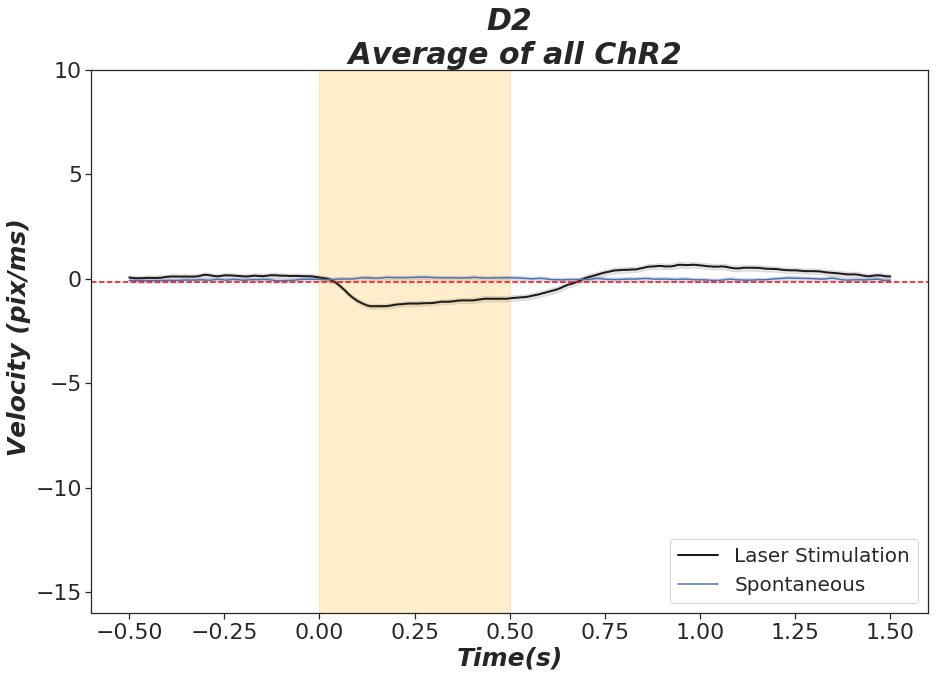

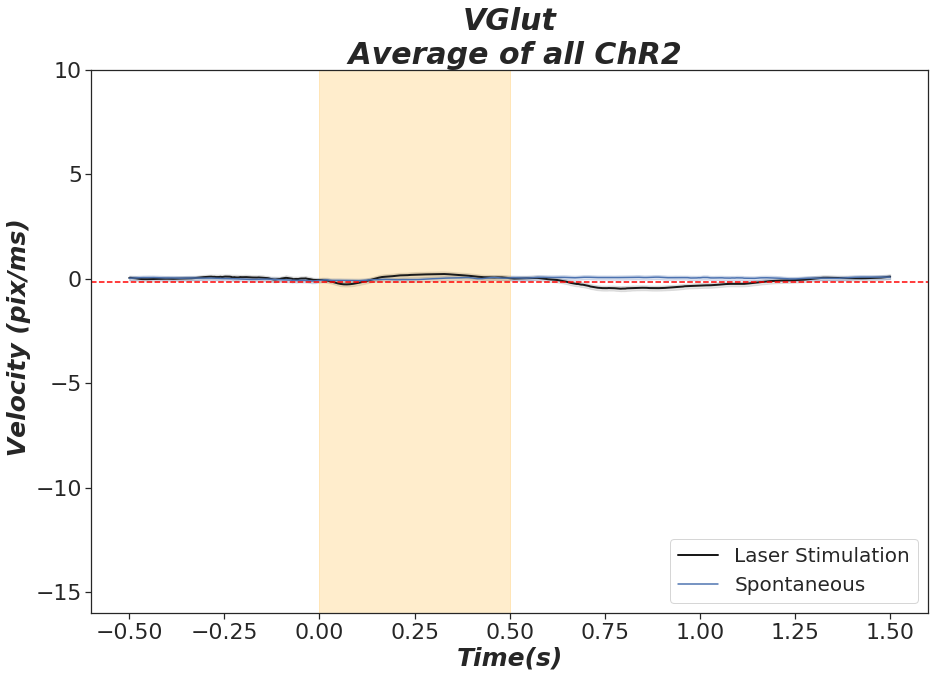

In [135]:
where_plot,which_plot = get_input_cor_body_part() # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user

min_y_pre_post= -16; max_y_pre_post = 10
folder = "Square_1_mW"
path =pre_direct+'data_npz/'+folder+'/ChR2/'
extension_summary = ".npz"
Summary_files_list = list_all_data_files(path,extension_summary)
count = 1

for file in Summary_files_list:
    count+=1
    print(file)
    dat = npzfile = np.load(path+file)
    properties=file.split("_")
    epochs_all_mice = dat['epochs_all_mice']*scale_pix_to_mm
    epochs_spont_all_mice = dat['epochs_spont_all_mice']*scale_pix_to_mm
    print(np.max(epochs_spont_all_mice))
#     epochs_spont_all_mice = np.zeros((epochs_all_mice.shape))
    global mouse_type; global opto_par
    mouse_type = properties[0]
    opto_par = properties[1]
    plt.figure(count)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
    plot_pre_on_post(epochs_all_mice,epochs_spont_all_mice,average = 'Averg_trials_all_mice')


## Plot pre-stimp-post all Control

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
D2_Control_Square_1_mW_mov_aver=8n_t=5.npz
['epochs_all_mice', 'epochs_mean_each_mouse']
FoxP2_Control_Square_1_mW_mov_aver=8n_t=5.npz
['epochs_all_mice', 'epochs_mean_each_mouse']
VGlut_Control_Square_1_mW_mov_aver=8n_t=5.npz
['epochs_all_mice', 'epochs_mean_each_mouse']


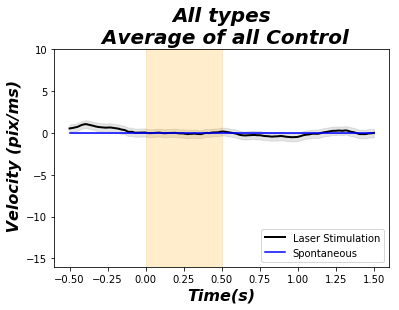

In [33]:
where_plot,which_plot = get_input_cor_body_part() # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user

min_y_pre_post= -16; max_y_pre_post = 10
folder = "Square_1_mW"
path =pre_direct+'data_npz/'+folder+'/Control/'
extension_summary = ".npz"
Summary_files_list = list_all_data_files(path,extension_summary)
epochs_all_ctr = np.empty((0,pre_interval+interval+post_interval+1))
epochs_spont_all_ctr = np.empty((0,pre_interval+interval+post_interval+1))
for file in Summary_files_list:

    print(file)
    dat = npzfile = np.load(path+file)
    print(dat.files)
    properties=file.split("_")
    epochs_all_ctr = np.append(epochs_all_ctr,dat['epochs_all_mice'], axis = 0)# construct an array of all the trial epochs of all mice
#     epochs_spont_all_ctr = np.append(epochs_spont_all_ctr,dat['epochs_spont_all_mice'], axis = 0)# construct an array of all the trial epochs of all mice

    epochs_spont_all_ctr = np.zeros((epochs_all_ctr.shape))
    global mouse_type; global opto_par
    mouse_type = 'All types'
    opto_par = properties[1]

plot_pre_on_post(epochs_all_ctr,epochs_spont_all_ctr,average = 'Averg_trials_all_mice')

## Look at the relative distance between Hind Limb and Tail in one epoch

# discarded epochs = 0
# discarded epochs = 0


NameError: name 'folder' is not defined

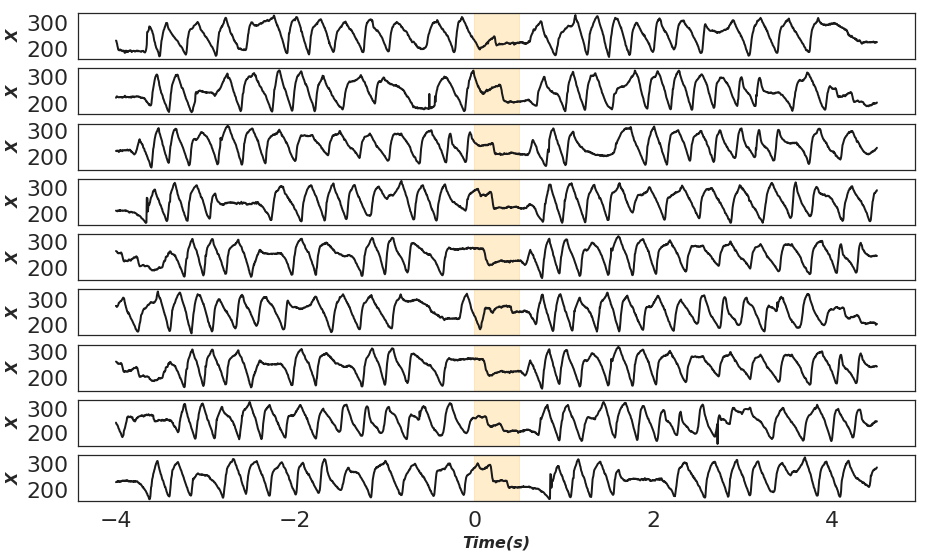

In [18]:
file_name_laser = '/home/shiva/Desktop/Shiva_Behavior/FoxP2/ChR2/Mouse_8/Square_HI_1/Laser/MouseFoxP2Cre_#8_SquarePulse_1mW_b18_Laser.xlsx' # name of your excel file
file_name_pos ='/home/shiva/Desktop/Shiva_Behavior/FoxP2/ChR2/Mouse_8/Square_HI_1/DLC/MouseFoxP2Cre_#8_SquarePulse_1mW_b18_DLC.xlsx'

VGlut_list = ([116, 117, 118, 119, 164, 165, 166],[359, 360]) #first list ChR2 second Control
D2_list = ([156, 165, 166, 195, 196, 198, 199],[172, 178])
FoxP2_list = ([8, 9, 10, 11, 27],[23, 26])

pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset

# folder = 'Beta_2_mW'
# file_name_laser = '/home/shiva/Desktop/Shiva_Behavior/FoxP2/ChR2/Mouse_8/Beta_2_mW/Laser/MouseFoxP2Cre_#8_BetaStim_2mW_h01_Laser.xlsx' # name of your excel file
# file_name_pos ='/home/shiva/Desktop/Shiva_Behavior/FoxP2/ChR2/Mouse_8/Beta_2_mW/DLC/MouseFoxP2Cre_#8_BetaStim_2mW_h01_DLC.xlsx'

between_stim = 250
df = read_DLC(file_name_pos)
laser_t = read_laser(file_name_laser)

time_series  = df.index / fps ## time axis in seconds for stimulation trial
trial_time = max(time_series)
bins  = np.array(laser_t.values).astype(int)
pre_interval = 1000;interval = 125; post_interval = 1000; n =10
epochs_Limb = extract_epochs(bins,df['rFL','x'].values,pre_interval,post_interval,interval)
epochs_Tail = extract_epochs(bins,df['rTail','x'].values,pre_interval,post_interval,interval)
epochs_Limb_rel = epochs_Limb-epochs_Tail
fig = plt.figure(figsize=(15,10))
for i in range(1,n):
    
    x = fig.add_subplot(n,1,i)
    random_num = np.random.randint(0,epochs_Limb_rel.shape[0])
    time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
    plt.plot(time_series, epochs_Limb_rel[random_num,:], color = 'k',linestyle='-',linewidth=2)#, marker='o',markersize=1)
    plt.axvspan(0, interval/fps, alpha=0.2, color='orange')
    plt.ylabel("X", fontproperties=font_label).set_fontproperties(font_label)
    plt.xlabel("Time(s)", fontproperties=font_label).set_fontproperties(font_label)
    
fig.suptitle("Hind Limb X-Position relative to the Tail"+'\n'+"FoxP2Cre "+folder, fontsize =20).set_fontproperties(font)
plt.savefig('/home/shiva/Desktop/Shiva_Behavior/Subplots/Limb_H.pdf',bbox_inches='tight',orientation='landscape',dpi=350)

plt.show()

## Look at a single measure in one session

/home/shiva/Desktop/
Select what you want to see: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. Position 
 2. Velocity 
 3. Acceleration
1
 1. X 
 2. Y 
1
 1. Right & Left 
 2. Average
2
2


<Figure size 432x288 with 0 Axes>

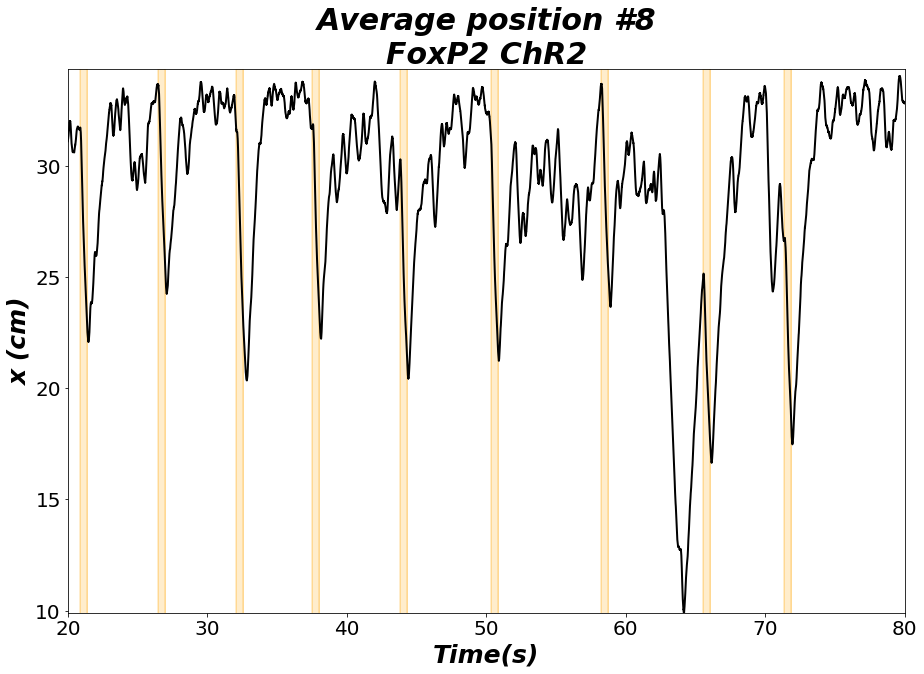

In [10]:
file_name_laser = '/home/shiva/Desktop/Shiva_Behavior/FoxP2/ChR2/Mouse_8/Square_1_mW/Laser/MouseFoxP2Cre_8-Square1mW-Bis-Laser.xlsx' # name of your excel file
file_name_pos ='/home/shiva/Desktop/Shiva_Behavior/FoxP2/ChR2/Mouse_8/Square_1_mW/DLC/MouseFoxP2Cre_8-Square1mW-Bis-DLC.xlsx'
path = '/home/shiva/Desktop/'
# file_name_laser = '/home/shiva/Desktop/Shiva_Behavior/D2/ChR2/Mouse_196/Square_1_mW/Laser/D2_196_STR_alone_1mW_square_pulses_b_13_Laser.xlsx' # name of your excel file
# file_name_pos ='/home/shiva/Desktop/Shiva_Behavior/D2/ChR2/Mouse_196/Square_1_mW/DLC/D2_196_STR_alone_1mW_square_pulses_b_13_DLC.xlsx'

mouse_no = 8
trial_no = 13
mouse_type = 'FoxP2'
# df = read_DLC(file_name_pos)
# laser_t = read_laser(file_name_laser)
min_x = 20 ; max_x = 80
time_series  = df.index / fps ## time axis in seconds for stimulation trial
trial_time = max(time_series)
print(path)
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
input_plot()
plt.show()

In [57]:
print(path)

/home/shiva/Desktop/Shiva_Behavior/data_npz/Square_1_mW/Control/


## Categorize trials by pre-laser acceleration/position

In [50]:

where_plot,which_plot = get_input_cor_body_part() # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user

intensity = '1'
opto_par = 'ChR2'
# opto_par = 'Control'
folder = 'Square_1_mW';  

# mouse_type = 'Vglut'
mouse_type = 'D2';
# mouse_type = 'FoxP2'
folder_spont = 'Spontaneous'
VGlut_list = ([116, 117, 118, 119, 164, 165, 166],[359, 360]) #first list ChR2 second Control
# D2_list = ([156, 165, 166, 195, 196, 198, 199],[172, 178])
D2_list = ([156, 165, 166, 195, 196, 198, 199],[172, 178])

FoxP2_list = ([8, 9, 10, 11, 24, 27],[23, 26])
smallest_accep_inter = 123; largest_accep_inter = 128 # criteria for discarding the detected laser epochs

# epochs_all_mice_pos = np.empty((0,pre_interval+interval+post_interval+1))
# epochs_all_mice_neg = np.empty((0,pre_interval+interval+post_interval+1))

# epochs_spont_all_mice = np.empty((0,pre_interval+interval+post_interval+1))
# epochs_mean_each_mouse_pos = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
# epochs_mean_each_mouse_neg = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice

epochs_all_mice_pos_front = np.empty((0,pre_interval+interval+post_interval+1))
epochs_all_mice_neg_front = np.empty((0,pre_interval+interval+post_interval+1))

epochs_mean_each_mouse_pos_front = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
epochs_mean_each_mouse_neg_front = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice

epochs_all_mice_pos_back = np.empty((0,pre_interval+interval+post_interval+1))
epochs_all_mice_neg_back = np.empty((0,pre_interval+interval+post_interval+1))

epochs_mean_each_mouse_pos_back = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
epochs_mean_each_mouse_neg_back = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice

epochs_min_each_mouse = np.empty((0,3)) # array storing the average of each period (OFF-ON-OFF) for all the mice
pre_stim_inter = 125 # number of timebins in the pre-stimulus period 
time_window = 5 # delta t to calculate the velocity and acceleration
window = 6 # window for moving average
n_bins = 45

extension = '.xlsx'
count = 0
min_x =200; max_y = 25 ; max_x = 2000
behind_limit = 1200 # set the limit below which is considered back of the treadmill

min_y_pre_post = -10 ; max_y_pre_post = 10

fig = plt.figure(figsize=(20,15))
outer = gridspec.GridSpec(3, 4, wspace=0.2, hspace=0.2)
# print(extension)
for n in D2_list[0]: # Run over all the mice
    count +=1
    start = timeit.default_timer()
    mouse_no = n
    pre_direct = "/home/shiva/Desktop/Shiva_Behavior/"
    direct = pre_direct + mouse_type +'/'+ opto_par + '/Mouse_' + str(mouse_no)+ '/'  # directory to the folder for each mouse

    files_list_DLC = list_all_data_files(direct+folder+'/DLC',extension)
    files_list_Laser = list_all_data_files(direct+folder+'/Laser',extension)
#     print(direct + folder)
#     print(files_list_DLC)
#     print(files_list_Laser)
    epochs = extract_epochs_over_trials(files_list_DLC,files_list_Laser,direct,folder,spont ='n') 
#     epochs_spont = extract_epochs_over_trials(files_list_spont,files_list_Laser,folder_spont,spont ='y')
    
    epochs_all_mice = np.append(epochs_all_mice, epochs, axis = 0)# construct an array of all the trial epochs of all mice
#     epochs_spont_all_mice = np.append(epochs_spont_all_mice, epochs_spont, axis = 0) # construct an array of all the spont epochs
    
#     temp = min_and_mean_on_off(epochs,pre_interval,post_interval,interval,'Mean')
#     average_of_on_off_on = np.average(temp,axis = 0).reshape(1,3)
#     epochs_mean_each_mouse = np.append(epochs_mean_each_mouse,average_of_on_off_on
#                                        ,axis = 0)
    epochs_spont = np.zeros(np.shape(epochs))
    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[count-1], wspace=0.1, hspace=0.1)
    
    ax = plt.Subplot(fig, inner[0])
    fig.add_subplot(ax)
    
    ## distiction by acceleration at laser onset
    pre_accel_epochs = extract_pre_laser_accel_epochs_over_trials(files_list_DLC,files_list_Laser,direct,folder, pre_stim_inter,time_window,window)
    pre_accel = np.average(pre_accel_epochs,axis = 1)
    ind_negative_accel = np.array(np.where(pre_accel<0)).T
    ind_negative_accel =  ind_negative_accel.reshape( ind_negative_accel.shape[0],)
    ind_positive_accel = np.array(np.where(pre_accel>0)).T
    ind_positive_accel =  ind_positive_accel.reshape( ind_positive_accel.shape[0],)
    print("#positive accel={}".format(len(ind_positive_accel)))
    print("#negative accel={}".format(len(ind_negative_accel)))
    
#     plot_pre_on_post(epochs[ind_negative_accel,:],epochs_spont,average = 'Averg_trials')
#     plt.title(mouse_type+" #"+str(mouse_no) +"\n"+" interval = "+ str(time_window)+" a>0" , fontsize=10)
#     plt.ylim(-10,8)
    ## distiction by x position at laser onset
    pre_x_position_epochs = extract_pre_laser_x_epochs_over_trials(files_list_DLC,files_list_Laser,folder, pre_stim_inter)
    pre_x_position = np.average(pre_x_position_epochs,axis = 1)
    ind_back_x = np.array(np.where(pre_x_position < behind_limit)).T
    ind_front_x = np.array(np.where(pre_x_position > behind_limit)).T
    ind_back_x = ind_back_x.reshape(ind_back_x.shape[0],)
    ind_front_x = ind_front_x.reshape(ind_front_x.shape[0],)
    print("#front={}".format(len(ind_front_x)))
    print("#back={}".format(len(ind_back_x)))
#     plot_pre_on_post(epochs[ind_back_x,:],epochs_spont,average = 'Averg_trials')
#     plt.title(mouse_type+" #"+str(mouse_no) +"\n"+"at back #trials= " +str(len(ind_back_x)), fontsize=10)

#     ax.get_legend().remove()
#     plt.ylabel("")
#     plt.ylim(-12,12)
    
#     x = fig.add_subplot(3,4,count)
#     epochs = extract_epochs_over_trials(files_list_DLC,files_list_Laser,direct,folder,spont ='n') 
# #     epochs_spont = extract_epochs_over_trials(files_list_spont,files_list_Laser,direct,folder_spont,spont ='y')
    ########################################## To save data with acceleration distinction
#     epochs_all_mice_pos = np.append(epochs_all_mice_pos, epochs[ind_positive_accel,:], axis = 0)# construct an array of all the trial epochs of all mice
#     epochs_all_mice_neg = np.append(epochs_all_mice_neg,epochs[ind_negative_accel,:], axis = 0)# construct an array of all the trial epochs of all mice
# # #     epochs_spont_all_mice = np.append(epochs_spont_all_mice, epochs_spont, axis = 0) # construct an array of all the spont epochs
    
#     temp = min_and_mean_on_off(epochs[ind_positive_accel,:],pre_interval,post_interval,interval,'Mean')
#     average_of_on_off_on = np.average(temp,axis = 0).reshape(1,3)
#     epochs_mean_each_mouse_pos = np.append(epochs_mean_each_mouse_pos,average_of_on_off_on
#                                        ,axis = 0)
#     temp = min_and_mean_on_off(epochs[ind_negative_accel,:],pre_interval,post_interval,interval,'Mean')
#     average_of_on_off_on = np.average(temp,axis = 0).reshape(1,3)
#     epochs_mean_each_mouse_neg = np.append(epochs_mean_each_mouse_neg,average_of_on_off_on
#                                        ,axis = 0)
    #############################################
    epochs_all_mice_pos_front = np.append(epochs_all_mice_pos_front, epochs[np.intersect1d(ind_positive_accel,ind_front_x),:], axis = 0)# construct an array of all the trial epochs of all mice
    epochs_all_mice_neg_front = np.append(epochs_all_mice_neg_front,epochs[np.intersect1d(ind_negative_accel,ind_front_x),:], axis = 0)# construct an array of all the trial epochs of all mice
    
    temp = min_and_mean_on_off(epochs[np.intersect1d(ind_positive_accel,ind_front_x),:],pre_interval,post_interval,interval,'Mean')
    average_of_on_off_on = np.average(temp,axis = 0).reshape(1,3)
    epochs_mean_each_mouse_pos_front = np.append(epochs_mean_each_mouse_pos_front,average_of_on_off_on
                                       ,axis = 0)
    temp = min_and_mean_on_off(epochs[np.intersect1d(ind_negative_accel,ind_front_x),:],pre_interval,post_interval,interval,'Mean')
    average_of_on_off_on = np.average(temp,axis = 0).reshape(1,3)
    epochs_mean_each_mouse_neg_front = np.append(epochs_mean_each_mouse_neg_front,average_of_on_off_on
                                       ,axis = 0)
    ## Back
    epochs_all_mice_pos_back = np.append(epochs_all_mice_pos_back, epochs[np.intersect1d(ind_positive_accel,ind_back_x),:], axis = 0)# construct an array of all the trial epochs of all mice
    epochs_all_mice_neg_back = np.append(epochs_all_mice_neg_back,epochs[np.intersect1d(ind_negative_accel,ind_back_x),:], axis = 0)# construct an array of all the trial epochs of all mice
    
    temp = min_and_mean_on_off(epochs[np.intersect1d(ind_positive_accel,ind_back_x),:],pre_interval,post_interval,interval,'Mean')
    average_of_on_off_on = np.average(temp,axis = 0).reshape(1,3)
    epochs_mean_each_mouse_pos_back = np.append(epochs_mean_each_mouse_pos_back,average_of_on_off_on
                                       ,axis = 0)
    temp = min_and_mean_on_off(epochs[np.intersect1d(ind_negative_accel,ind_back_x),:],pre_interval,post_interval,interval,'Mean')
    average_of_on_off_on = np.average(temp,axis = 0).reshape(1,3)
    epochs_mean_each_mouse_neg_back = np.append(epochs_mean_each_mouse_neg_back,average_of_on_off_on
                                       ,axis = 0)
      
    #############################################
#     ax = plt.Subplot(fig, inner[1])
#     fig.add_subplot(ax)
    
#     plot_pre_on_post(epochs[ind_positive_accel,:],epochs_spont,average = 'Averg_trials')
#     plt.title(mouse_type+" #"+str(mouse_no) +"\n"+" interval = "+ str(time_window)+" a<0" , fontsize=10)
    
# #     plot_pre_on_post(epochs[ind_front_x,:],epochs_spont,average = 'Averg_trials')
# #     plt.title(mouse_type+" #"+str(mouse_no) +"\n"+"in front #trials= " +str(len(ind_front_x)) , fontsize=10)

    stop = timeit.default_timer()
    print('run time = ',stop-start)
#     ax.get_legend().remove()
#     plt.ylabel("")
#     plt.ylim(-10,8)
    
# plt.suptitle('D2 Cre '+'\n'+'intensity='+intensity+' mW'+'pre stim window='+str(pre_stim_inter),fontsize= 30,y = 1)

# plt.tight_layout()
# plt.savefig(pre_direct+'Subplots'+'/Pre_laser_accel_distinction_'+opto_par+'_'+mouse_type+'_' +
#             '.png',bbox_inches='tight',orientation='landscape',dpi=400)

# # plt.savefig(pre_direct+'Subplots'+'/Pre_laser_x_distinction_'+opto_par+'_'+mouse_type+'_' +
# #             '.png',bbox_inches='tight',orientation='landscape',dpi=400)
# plt.show()



Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb


KeyboardInterrupt: 

## Save data organized by pre-laser acceleration/position

In [99]:
## Only accel
# file_name = mouse_type+'_'+opto_par+'_'+intensity+'_Square'+"_pos_accel_mov_aver"
# np.savez( os.path.join(pre_direct+'data_npz/'+'accel', file_name),
#          epochs_all_mice_pos=epochs_all_mice_pos,
#          epochs_mean_each_mouse_pos=epochs_mean_each_mouse_pos)
# dat = npzfile = np.load(pre_direct+'data_npz/'+'accel/'+file_name+'.npz')
# print(dat.files)

# file_name = mouse_type+'_'+opto_par+'_'+intensity+'_Square'+"_neg_accel_mov_aver"
# np.savez( os.path.join(pre_direct+'data_npz/'+'accel', file_name),
#          epochs_all_mice_neg=epochs_all_mice_neg,
#          epochs_mean_each_mouse_neg=epochs_mean_each_mouse_neg)
# dat = npzfile = np.load(pre_direct+'data_npz/'+'accel/'+file_name+'.npz')
# print(dat.files)
##################
### accel and x
#front
file_name = mouse_type+'_'+opto_par+'_'+intensity+'_Square'+"_pos_front_mov_aver"
np.savez( os.path.join(pre_direct+'data_npz/'+'accel', file_name),
         epochs_all_mice_pos_front=epochs_all_mice_pos_front,
         epochs_mean_each_mouse_pos_front=epochs_mean_each_mouse_pos_front)
dat = npzfile = np.load(pre_direct+'data_npz/'+'accel/'+file_name+'.npz')
print(dat.files)

file_name = mouse_type+'_'+opto_par+'_'+intensity+'_Square'+"_neg_front_mov_aver"
np.savez( os.path.join(pre_direct+'data_npz/'+'accel', file_name),
         epochs_all_mice_neg_front=epochs_all_mice_neg_front,
         epochs_mean_each_mouse_neg_front=epochs_mean_each_mouse_neg_front)
dat = npzfile = np.load(pre_direct+'data_npz/'+'accel/'+file_name+'.npz')
print(dat.files)
### back
file_name = mouse_type+'_'+opto_par+'_'+intensity+'_Square'+"_pos_back_mov_aver"
np.savez( os.path.join(pre_direct+'data_npz/'+'accel', file_name),
         epochs_all_mice_pos_back=epochs_all_mice_pos_back,
         epochs_mean_each_mouse_pos_back=epochs_mean_each_mouse_pos_back)
dat = npzfile = np.load(pre_direct+'data_npz/'+'accel/'+file_name+'.npz')
print(dat.files)

file_name = mouse_type+'_'+opto_par+'_'+intensity+'_Square'+"_neg_back_mov_aver"
np.savez( os.path.join(pre_direct+'data_npz/'+'accel', file_name),
         epochs_all_mice_neg_back=epochs_all_mice_neg_back,
         epochs_mean_each_mouse_neg_back=epochs_mean_each_mouse_neg_back)
dat = npzfile = np.load(pre_direct+'data_npz/'+'accel/'+file_name+'.npz')
print(dat.files)

FileNotFoundError: [Errno 2] No such file or directory: '/home/shiva/Desktop/Shiva_Behavior/data_npz/accel/D2_ChR2_1_Square_pos_front_mov_aver.npz'

D2_ChR2_0.5_Square_neg_accel_mov_aver.npz
['epochs_all_mice_neg', 'epochs_mean_each_mouse_neg']
D2_ChR2_0.5_Square_neg_back_mov_aver.npz
['epochs_all_mice_neg_back', 'epochs_mean_each_mouse_neg_back']
D2_ChR2_0.5_Square_neg_front_mov_aver.npz
['epochs_all_mice_neg_front', 'epochs_mean_each_mouse_neg_front']
D2_ChR2_0.5_Square_pos_accel_mov_aver.npz
['epochs_all_mice_pos', 'epochs_mean_each_mouse_pos']
D2_ChR2_0.5_Square_pos_back_mov_aver.npz
['epochs_all_mice_pos_back', 'epochs_mean_each_mouse_pos_back']
D2_ChR2_0.5_Square_pos_front_mov_aver.npz
['epochs_all_mice_pos_front', 'epochs_mean_each_mouse_pos_front']
D2_ChR2_1_Square_neg_accel_mov_aver.npz
['epochs_all_mice_neg', 'epochs_mean_each_mouse_neg']
D2_ChR2_1_Square_neg_back_mov_aver.npz
['epochs_all_mice_neg_back', 'epochs_mean_each_mouse_neg_back']
D2_ChR2_1_Square_neg_front_mov_aver.npz
['epochs_all_mice_neg_front', 'epochs_mean_each_mouse_neg_front']
D2_ChR2_1_Square_pos_accel_mov_aver.npz
['epochs_all_mice_pos', 'epochs_mean_ea

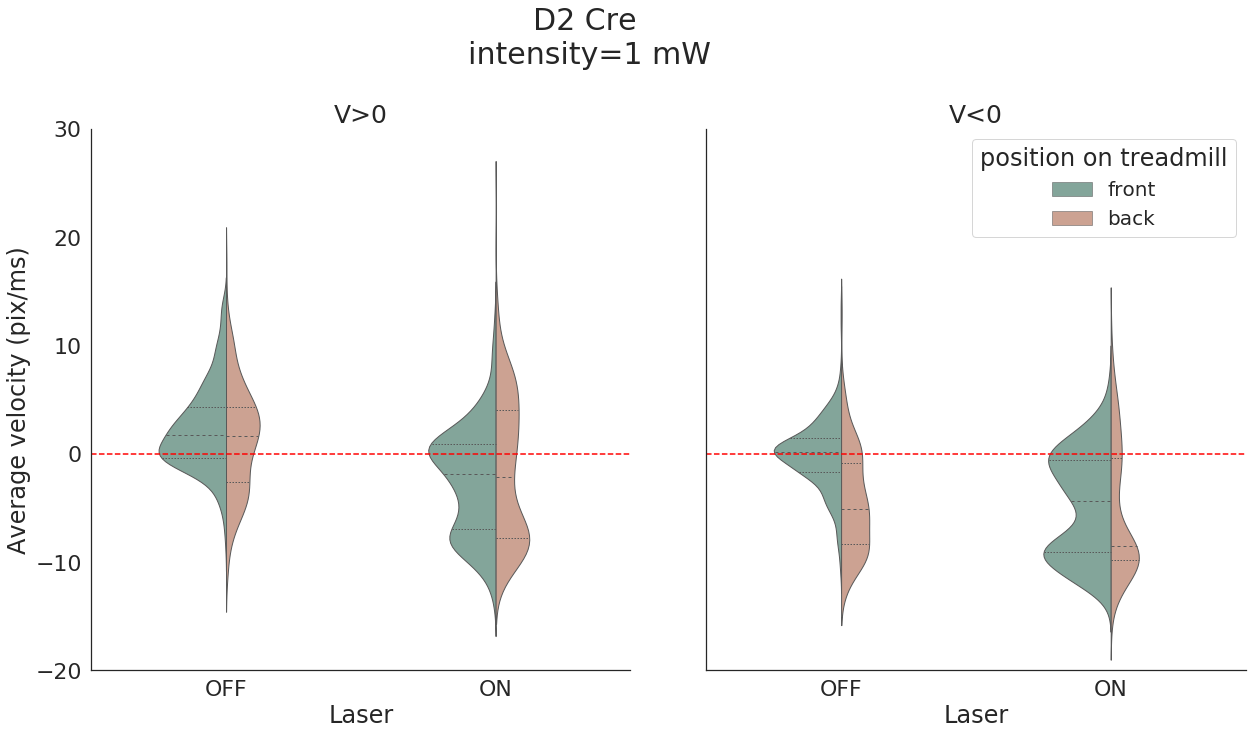

In [96]:
interval = 125 # number of timebins of stimulation 
fps = 250
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset

path = "/Users/apple/Desktop/data_npz/"
path =pre_direct+'data_npz/accel/'
extension = ".npz"
Summary_files_list = list_all_data_files(path,extension)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch','velocity']
result = pd.DataFrame(columns = col_names)



for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(path+file)
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    print(dat.files)
    ## data for individual plot lines of mice
#     if properties[4]=='pos' and properties[1] != 'Control':
#         epochs_mean_mouse_pos = dat[dat.files[1]]
#     if properties[4]=='neg'and properties[1] != 'Control':
#         epochs_mean_mouse_neg = dat[dat.files[1]]
 
    ### set the variables of epoch/optogen/pulse type/mouse type/velocity and x of pre stim
    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[3]] * epochs.shape[0]*2
    Velocity_ = [properties[4]]* epochs.shape[0]*2
    x_ = [properties[5]]* epochs.shape[0]*2
#     intensity, data_type = properties[4].split('.')
    inten_ = [properties[2]] * epochs.shape[0]*2
  
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
    epoch_off = ['OFF'] * epochs.shape[0]
    epoch_on = ['ON'] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    # append the data of each mouse to a unit dataframe
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_,'velocity':Velocity_,'x':x_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
# print(result)

import seaborn as sns

# g = sns.FacetGrid(result, col="mouse_type", size=5, aspect=1.5)
sns.set_style("white")
# path = "/Users/apple/Desktop/data_npz/"

g = sns.catplot(x="epoch", y="mean_velocity",
                hue="x", col="velocity",
                data=result, kind="violin", split=True, palette = sns.color_palette("Set2", n_colors=2, desat=.5),
                height=5, scale_hue=False, linewidth = 1, inner="quartile", scale = 'count',
                hue_order=['front','back'],col_order=['pos','neg'],legend = False,width=.5)
x_series = [0.3,0.6]
ax1, ax2 = g.axes[0]
### plot the data of each mice together with the violin plot
# for i in range (epochs_mean_mouse_pos.shape[0]):
#     ax1.plot(x_series,epochs_mean_mouse_pos[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
#     ax1.plot(x_series,np.average(epochs_mean_mouse_pos[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

# for i in range (epochs_mean_mouse_neg.shape[0]):
#     ax2.plot(x_series,epochs_mean_mouse_neg[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
#     ax2.plot(x_series,np.average(epochs_mean_mouse_neg[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)


sns.set(font_scale = 2)
sns.set_style("white")
plt.ylim([-20,30])
ax1, ax2 = g.axes[0]
ax1.axhline( y=0, ls='--', c='red')
ax2.axhline( y=0, ls='--', c='red')

ax1.set_title('V>0', y=0.95, fontsize = 25)
ax2.set_title('V<0', y=0.95, fontsize = 25)

g.set_axis_labels("Laser", "Average velocity (pix/ms)")
plt.suptitle('D2 Cre '+'\n'+'intensity='+intensity+' mW',fontsize= 30,y = 1)
g.fig.set_figwidth(20.0)
g.fig.set_figheight(12)
# legend = plt.legend(loc='upper right', title='Optogenetic Expression',fontsize= 20)
legend = plt.legend(loc='upper right', title='position on treadmill',fontsize= 20)

plt.savefig(path+'plot_1mW.png',bbox_inches='tight',orientation='landscape',dpi=350)



## Save all epochs of a mouse type to .npz

In [19]:
file_name = mouse_type+'_'+opto_par+'_'+folder+"_mov_aver"
np.savez( os.path.join(pre_direct+'data_npz', file_name),
         epochs_all_mice=epochs_all_mice,
         epochs_mean_each_mouse=epochs_mean_each_mouse)
dat = npzfile = np.load(pre_direct+'data_npz/'+file_name+'.npz')
dat.files

['epochs_all_mice', 'epochs_mean_each_mouse']

## Look at the results of different intensity on FoxP2

FoxP2_ChR2_Beta_0-5_mW_mov_aver.npz
['epochs_all_mice', 'epochs_mean_each_mouse']
FoxP2_ChR2_Beta_1_mW_mov_aver.npz
['epochs_all_mice', 'epochs_mean_each_mouse']
FoxP2_ChR2_Beta_2_mW_mov_aver.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'FoxP2_ChR2_Beta_5_mW_mov_aver.npz']
FoxP2_ChR2_Beta_5_mW_mov_aver.npz
['epochs_all_mice', 'epochs_mean_each_mouse']
FoxP2_Control_Beta_5_mW_mov_aver.npz
['epochs_all_mice', 'epochs_mean_each_mouse']


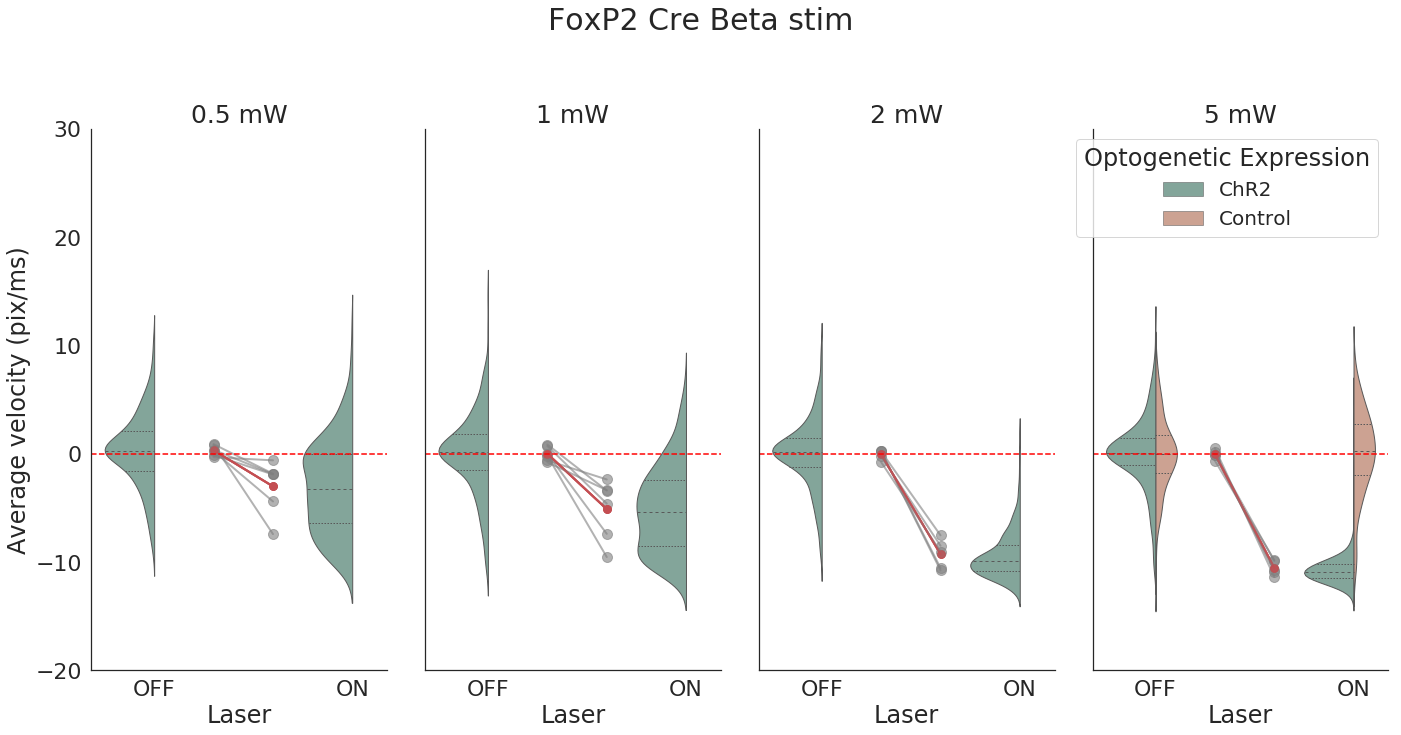

In [19]:
interval = 125 # number of timebins of stimulation 
fps = 250
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset

path = "/Users/apple/Desktop/data_npz/"
path =pre_direct+'data_npz/BetaStim/'
extension = ".npz"
Summary_files_list = list_all_data_files(path,extension)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch']
result = pd.DataFrame(columns = col_names)



for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(path+file)
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    print(dat.files)
    ## data for individual plot points of mice
    if properties[3]=='0-5' and properties[1] != 'Control':
        epochs_mean_mouse_0_5 = dat[dat.files[1]]
        min_arg_0_25 = np.argmin(epochs[:,pre_interval+1:pre_interval+interval+1], axis = 1)
    if properties[3]=='1'and properties[1] != 'Control':
        epochs_mean_mouse_1 = dat[dat.files[1]]
    if properties[3]=='2'and properties[1] != 'Control':
        epochs_mean_mouse_2 = dat[dat.files[1]]
    if properties[3]=='5'and properties[1] != 'Control':
        epochs_mean_mouse_5 = dat[dat.files[1]]

    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
#     intensity, data_type = properties[4].split('.')
    inten_ = [properties[3]] * epochs.shape[0]*2
  
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
    epoch_off = ['OFF'] * epochs.shape[0]
    epoch_on = ['ON'] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
# print(result.head())

import seaborn as sns

# g = sns.FacetGrid(result, col="mouse_type", size=5, aspect=1.5)
sns.set_style("white")
# path = "/Users/apple/Desktop/data_npz/"

g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression", col="intensity_mW",
                data=result, kind="violin", split=True, palette = sns.color_palette("Set2", n_colors=2, desat=.5),
                height=5, scale_hue=False, linewidth = 1, inner="quartile", scale = 'count',
                hue_order=['ChR2','Control'],col_order=['0-5','1','2', '5'],legend = False,width=.5)
x_series = [0.3,0.6]
ax1, ax2, ax3, ax4 = g.axes[0]
for i in range (epochs_mean_mouse_0_5.shape[0]):
    ax1.plot(x_series,epochs_mean_mouse_0_5[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax1.plot(x_series,np.average(epochs_mean_mouse_0_5[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_1.shape[0]):
    ax2.plot(x_series,epochs_mean_mouse_1[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax2.plot(x_series,np.average(epochs_mean_mouse_1[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_2.shape[0]):
    ax3.plot(x_series,epochs_mean_mouse_2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax3.plot(x_series,np.average(epochs_mean_mouse_2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)
for i in range (epochs_mean_mouse_5.shape[0]):
    ax4.plot(x_series,epochs_mean_mouse_5[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax4.plot(x_series,np.average(epochs_mean_mouse_5[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

sns.set(font_scale = 2)
sns.set_style("white")
plt.ylim([-20,30])
ax1, ax2, ax3 , ax4= g.axes[0]
ax1.axhline( y=0, ls='--', c='red')
ax2.axhline( y=0, ls='--', c='red')
ax3.axhline( y=0, ls='--', c='red')
ax4.axhline( y=0, ls='--', c='red')
ax1.set_title('0.5 mW', y=0.95, fontsize = 25)
ax2.set_title('1 mW', y=0.95, fontsize = 25)
ax3.set_title('2 mW', y=0.95, fontsize = 25)
ax4.set_title('5 mW', y=0.95, fontsize = 25)

g.set_axis_labels("Laser", "Average velocity (pix/ms)")
plt.suptitle('FoxP2 Cre Beta stim',fontsize= 30,y = 1)
g.fig.set_figwidth(20.0)
g.fig.set_figheight(12)
legend = plt.legend(loc='upper right', title='Optogenetic Expression',fontsize= 20)
plt.savefig(path+'All_Beta_FoxP2.pdf',bbox_inches='tight',orientation='landscape',dpi=350)



# In the next cells we look at the violin plots of all the data for different intensities

## Intensity = 1 mW without control

D2_ChR2_Square_1_mW_mov_aver=8n_t=5.npz
(748, 501)
FoxP2_ChR2_Square_1_mW_mov_aver=8n_t=5.npz
(711, 501)
VGlut_ChR2_Square_1_mW_mov_aver=8n_t=5.npz
(778, 501)


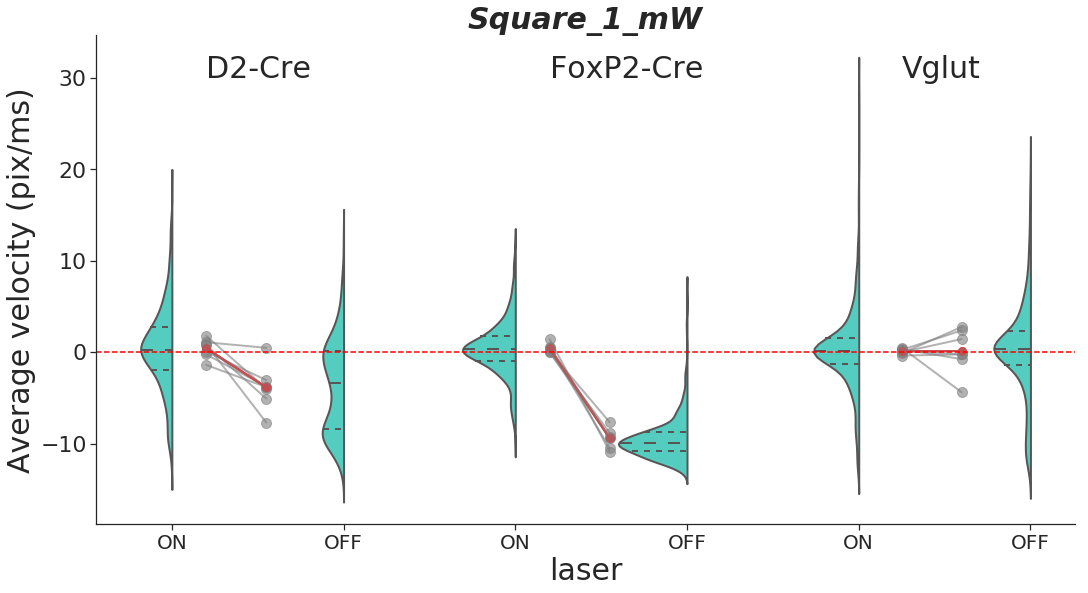

In [109]:

# path = "/Users/apple/Desktop/data_npz/"
folder = "Square_1_mW"
path =pre_direct+'data_npz/'+folder+'/ChR2/'
extension_summary = ".npz"
Summary_files_list = list_all_data_files(path,extension_summary)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch']
result = pd.DataFrame(columns = col_names)

# direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse


for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(path+file)
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    ## data for individual plot points of mice
    if properties[0]=='VGlut' and properties[1] != 'Control':
        epochs_mean_mouse_Vglut = dat[dat.files[1]]
    if properties[0]=='D2'and properties[1] != 'Control':
        epochs_mean_mouse_D2 = dat[dat.files[1]]
    if properties[0]=='FoxP2'and properties[1] != 'Control':
        epochs_mean_mouse_FoxP2 = dat[dat.files[1]]
        
    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
    inten_ = [properties[3]] * epochs.shape[0]*2
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
    epoch_off = ['OFF'+properties[0]] * epochs.shape[0]
    epoch_on = ['ON'+properties[0]] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    print(epochs.shape)
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
result.head()

import seaborn as sns
sns.set(font_scale = 2)
sns.set_style("white")

g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression", 
                data=result, kind="violin",  palette= ['turquoise'],
                height=5,  scale_hue=False,linewidth = 2, inner="quartile",split=True,scale ='area',
                hue_order=['ChR2','Control'],legend = False, gridsize = 100 )
x_series = [0.2,0.55]
ax1 = g.axes[0]
plt.text(min(x_series), 30, 'D2-Cre', fontsize=30)
for i in range (epochs_mean_mouse_D2.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_D2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    plt.plot(x_series,np.average(epochs_mean_mouse_D2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)
x_series = [4.25,4.6]
plt.text(min(x_series), 30, 'Vglut', fontsize=30)
for i in range (epochs_mean_mouse_Vglut.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_Vglut[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    plt.plot(x_series,np.average(epochs_mean_mouse_Vglut[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)
x_series = [2.2,2.55]
plt.text(min(x_series), 30, 'FoxP2-Cre', fontsize=30)
for i in range (epochs_mean_mouse_FoxP2.shape[0]):
    
    plt.plot(x_series,epochs_mean_mouse_FoxP2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    plt.plot(x_series,np.average(epochs_mean_mouse_FoxP2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

axes = g.axes.flatten()
plt.axhline( y=0, ls='--', c='red')
axes[0].set_xlabel("laser",fontsize=30)
axes[0].set_ylabel("Average velocity (pix/ms)",fontsize=30)
axes[0].get_xaxis().set_tick_params(direction='out')
axes[0].xaxis.set_ticks_position('bottom')
axes[0].get_yaxis().set_tick_params(direction='out')
axes[0].yaxis.set_ticks_position('left')

axes[0].set_xticklabels(['ON','OFF', 'ON','OFF', 'ON','OFF'],fontsize = 20)
plt.title(folder).set_fontproperties(font)
g.fig.set_figwidth(25.0)
g.fig.set_figheight(10)
# legend = plt.legend(loc='upper right', title='Optogenetic Expression',fontsize= 20)
plt.savefig(path+folder+'_ChR2.pdf',bbox_inches='tight',orientation='landscape',dpi=500)



## Intensity = 1  mW Control

D2_Control_Square_1_mW_mov_aver=8n_t=5.npz
(227, 501)
FoxP2_Control_Square_1_mW_mov_aver=8n_t=5.npz
(223, 501)
VGlut_Control_Square_1_mW_mov_aver=8n_t=5.npz
(158, 501)
(2, 3)


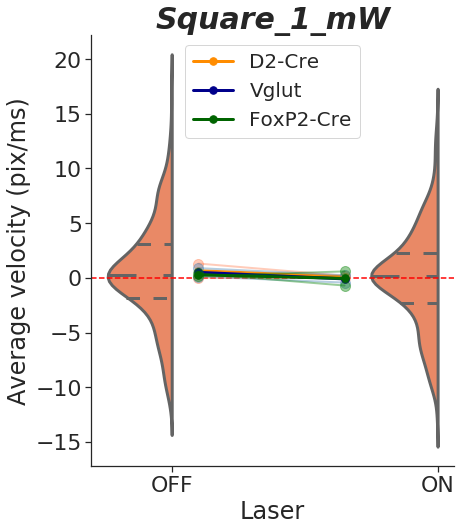

In [113]:

# path = "/Users/apple/Desktop/data_npz/"
folder = "Square_1_mW"
path =pre_direct+'data_npz/'+folder+'/Control/'
extension_summary = ".npz"
Summary_files_list = list_all_data_files(path,extension_summary)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch']
result = pd.DataFrame(columns = col_names)

# direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse


for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(path+file)
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    ## data for individual plot points of mice
    if properties[0]=='VGlut':
        epochs_mean_mouse_Vglut = dat[dat.files[1]]
    if properties[0]=='D2':
        epochs_mean_mouse_D2 = dat[dat.files[1]]
    if properties[0]=='FoxP2':
        epochs_mean_mouse_FoxP2 = dat[dat.files[1]]
        
    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
    inten_ = [properties[3]] * epochs.shape[0]*2
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
    epoch_off = ['OFF'] * epochs.shape[0]
    epoch_on = ['ON'] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    print(epochs.shape)
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
result.head()

import seaborn as sns
sns.set(font_scale = 2)

sns.set_style("white")

g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression", 
                data=result, kind="violin",  palette= ['coral'],
                height=4,  scale_hue=False,linewidth = 3, inner="quartile",split=True,scale ='area',width = 0.5,
                hue_order=['Control','ChR2'],legend = False, label='_nolegend_')
plt.axhline( y=0, ls='--', c='red')

x_series = [0.1,0.65]
ax1 = g.axes[0]
axes = g.axes.flatten()
# plt.text(min(x_series), 30, 'D2-Cre', fontsize=22)
for i in range (epochs_mean_mouse_D2.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_D2[i,:2],'-',color = 'coral',marker = 'o',markersize=10,linewidth=2,alpha=0.4)
plt1,=plt.plot(x_series,np.average(epochs_mean_mouse_D2[:,:2],axis =0),'.-',
             color = 'darkorange',marker = '.',markersize=15,linewidth=3,alpha=1, label = 'D2-Cre')

for i in range (epochs_mean_mouse_Vglut.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_Vglut[i,:2],'-',color = 'steelblue',marker = 'o',markersize=10,linewidth=2,alpha=0.4)
plt2,=plt.plot(x_series,np.average(epochs_mean_mouse_Vglut[:,:2],axis =0),'.-'
             ,color = 'darkblue',marker = '.',markersize=15,linewidth=3,alpha=1, label ='Vglut')

for i in range (epochs_mean_mouse_FoxP2.shape[0]):
    plt.plot(x_series,epochs_mean_mouse_FoxP2[i,:2],'-',color = 'green',marker = 'o',markersize=10,linewidth=2,alpha=0.4)
plt3,=plt.plot(x_series,np.average(epochs_mean_mouse_FoxP2[:,:2],axis =0),'.-'
             ,color = 'darkgreen',marker = '.',markersize=15,linewidth=3,alpha=1,label = 'FoxP2-Cre')

g.set_axis_labels("Laser", "Average velocity (cm/s)")

axes[0].get_xaxis().set_tick_params(direction='out')
axes[0].xaxis.set_ticks_position('bottom')
axes[0].get_yaxis().set_tick_params(direction='out')
axes[0].yaxis.set_ticks_position('left')

plt.title(folder).set_fontproperties(font)
g.fig.set_figwidth(10.0)
g.fig.set_figheight(10)
plt.legend(handles=[plt1,plt2,plt3],labels=['D2-Cre','Vglut','FoxP2-Cre'],loc = 'upper center',fontsize =20)
plt.savefig(path+folder+'_Control.pdf',bbox_inches='tight',orientation='landscape',dpi=500)
# pylab.legend([plt1,plt2,plt3],['moved points','moved points','moved points'], loc = 'upper left')
print(epochs_mean_mouse_Vglut.shape)

## intensity = 1mW with Control

D2_ChR2_Square_HI_1_mov_aver.npz
(748, 501)
D2_Control_Square_HI_1.npz
(228, 501)
FoxP2_ChR2_Square_HI_1_mov_aver.npz
(711, 501)
FoxP2_Control_Square_HI_1.npz
(223, 501)
Vglut_ChR2_Square_HI_1_mov_aver.npz
(778, 501)
Vglut_Control_Square_HI_1.npz
(158, 501)


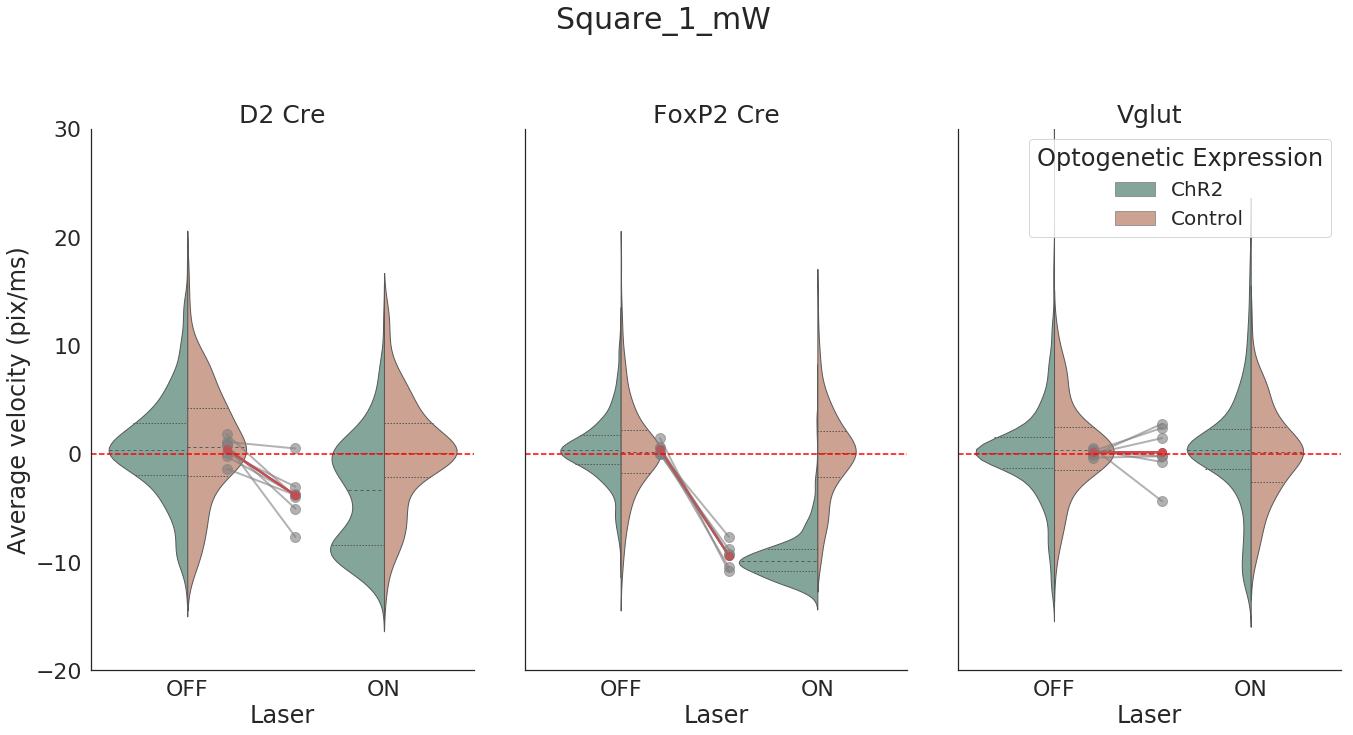

In [16]:

# path = "/Users/apple/Desktop/data_npz/"
folder = "Square_1_mW"
path =pre_direct+'data_npz/'+folder+'/'
extension_summary = ".npz"
Summary_files_list = list_all_data_files(path,extension_summary)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch']
result = pd.DataFrame(columns = col_names)

# direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse


for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(path+file)
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    ## data for individual plot points of mice
    if properties[0]=='Vglut' and properties[1] != 'Control':
        epochs_mean_mouse_Vglut = dat[dat.files[1]]
    if properties[0]=='D2'and properties[1] != 'Control':
        epochs_mean_mouse_D2 = dat[dat.files[1]]
    if properties[0]=='FoxP2'and properties[1] != 'Control':
        epochs_mean_mouse_FoxP2 = dat[dat.files[1]]
        
    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
#     intensity, data_type = properties[4].split('.')
    inten_ = [properties[4]] * epochs.shape[0]*2
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
    epoch_off = ['OFF'] * epochs.shape[0]
    epoch_on = ['ON'] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    print(epochs.shape)
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
result.head()

import seaborn as sns

sns.set_style("white")

g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression", col="mouse_type",
                data=result, kind="violin", split=True, palette = sns.color_palette("Set2", n_colors=2, desat=.5),
                height=5, scale_hue=False, linewidth = 1, inner="quartile", scale = 'area',
                hue_order=['ChR2','Control'],col_order=['D2','FoxP2','Vglut'],legend = False)
x_series = [0.2,0.55]
ax1, ax2, ax3 = g.axes[0]
for i in range (epochs_mean_mouse_Vglut.shape[0]):
    ax3.plot(x_series,epochs_mean_mouse_Vglut[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax3.plot(x_series,np.average(epochs_mean_mouse_Vglut[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_D2.shape[0]):
    ax1.plot(x_series,epochs_mean_mouse_D2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax1.plot(x_series,np.average(epochs_mean_mouse_D2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_FoxP2.shape[0]):
    ax2.plot(x_series,epochs_mean_mouse_FoxP2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax2.plot(x_series,np.average(epochs_mean_mouse_FoxP2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

sns.set(font_scale = 2)
sns.set_style("white")
plt.ylim([-20,30])
# plt.xlim([-2,2])
ax1, ax2, ax3 = g.axes[0]
ax1.axhline( y=0, ls='--', c='red')
ax2.axhline( y=0, ls='--', c='red')
ax3.axhline( y=0, ls='--', c='red')
ax1.set_title('D2 Cre', y=0.95, fontsize = 25)
ax2.set_title('FoxP2 Cre', y=0.95, fontsize = 25)
ax3.set_title('Vglut', y=0.95, fontsize = 25)
g.set_axis_labels("Laser", "Average velocity (pix/ms)")
plt.suptitle(folder,fontsize= 30,y = 1)
g.fig.set_figwidth(20.0)
g.fig.set_figheight(12)
legend = plt.legend(loc='upper right', title='Optogenetic Expression',fontsize= 20)
plt.savefig(path+folder+'.pdf',bbox_inches='tight',orientation='landscape',dpi=350)



## Intensity = 0.5 mW

D2_ChR2_Beta_0-5_mW_mov_aver.npz
D2_Control_Beta_0-5_mW_mov_aver.npz
FoxP2_ChR2_Beta_0-5_mW_mov_aver.npz
FoxP2_Control_Beta_0-5_mW_mov_aver.npz
VGlut_ChR2_Beta_0-5_mW_mov_aver.npz
VGlut_Control_Beta_0-5_mW_mov_aver.npz


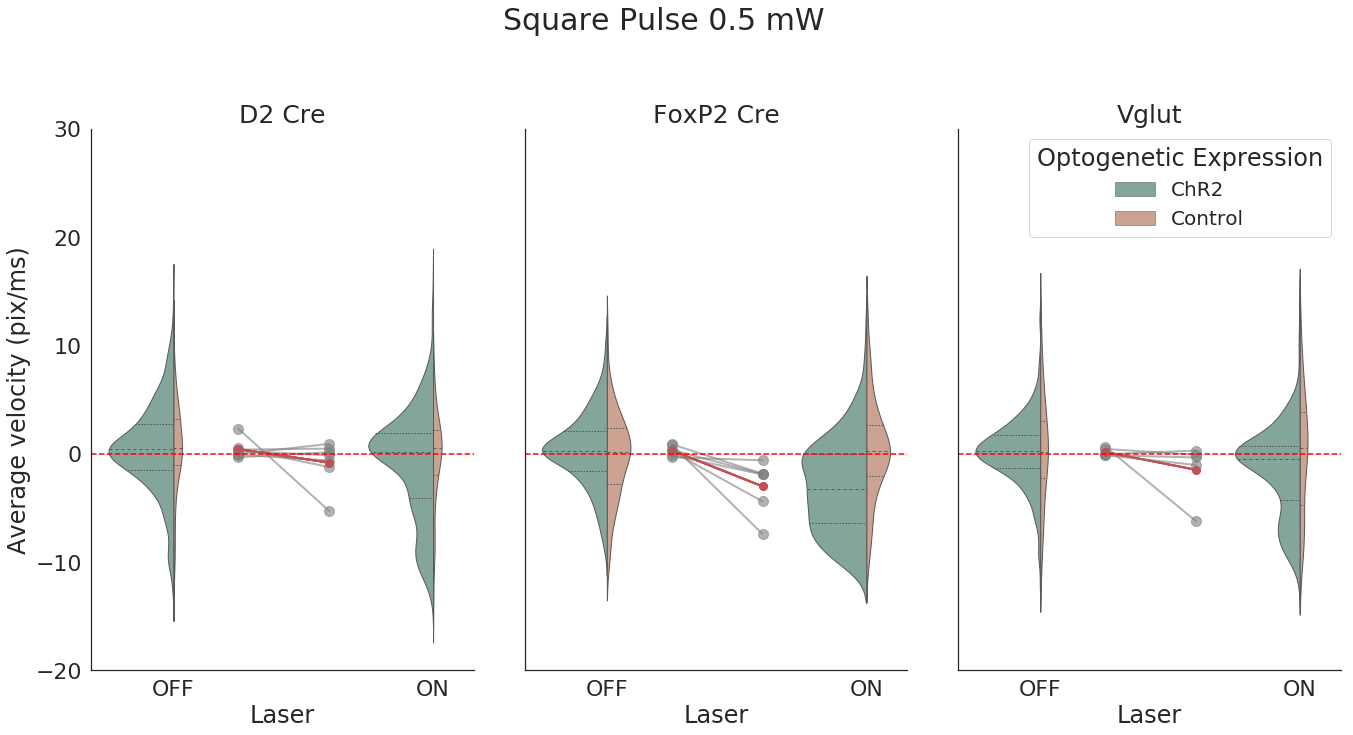

In [65]:
interval = 125 # number of timebins of stimulation 
fps = 250
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset

# path = "/Users/apple/Desktop/data_npz_mov_avg/"
path = pre_direct+'data_npz/BetaStim/0-5_mW/'
extension = ".npz"
Summary_files_list = list_all_data_files(path,extension)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch']
result = pd.DataFrame(columns = col_names)



for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(path+file)
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    ## data for individual plot points of mice
    if properties[0]=='VGlut' and properties[1] != 'Control':
        epochs_mean_mouse_Vglut = dat[dat.files[1]]
    if properties[0]=='D2'and properties[1] != 'Control':
        epochs_mean_mouse_D2 = dat[dat.files[1]]
    if properties[0]=='FoxP2'and properties[1] != 'Control':
        epochs_mean_mouse_FoxP2 = dat[dat.files[1]]
        
    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
    
    inten_ = [properties[3]] * epochs.shape[0]*2
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
    epoch_off = ['OFF'] * epochs.shape[0]
    epoch_on = ['ON'] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
    
# print(result.head())
# plt.rcParams["axes.labelsize"] = 15
sns.set(font_scale = 2)
sns.set_style("white")
g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression", col="mouse_type",
                data=result, kind="violin", split=True, palette = sns.color_palette("Set2", n_colors=2, desat=.5),
                height=5, scale_hue=False, linewidth = 1, inner="quartile",scale='count',
                hue_order=['ChR2','Control'],col_order=['D2','FoxP2','VGlut'],legend=False,width=.5)


x_series = [0.25,0.6]
ax1, ax2, ax3 = g.axes[0]
for i in range (epochs_mean_mouse_Vglut.shape[0]):
    ax3.plot(x_series,epochs_mean_mouse_Vglut[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax3.plot(x_series,np.average(epochs_mean_mouse_Vglut[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_D2.shape[0]):
    ax1.plot(x_series,epochs_mean_mouse_D2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax1.plot(x_series,np.average(epochs_mean_mouse_D2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_FoxP2.shape[0]):
    ax2.plot(x_series,epochs_mean_mouse_FoxP2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax2.plot(x_series,np.average(epochs_mean_mouse_FoxP2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

# set(xlim=(0,2),ylim=(-20,30))
plt.ylim([-20,30])
ax1.axhline( y=0, ls='--', c='red');#ax1.axhline( y=-15, ls='--', c='red')
ax2.axhline( y=0, ls='--', c='red');#ax1.axhline( y=-15, ls='--', c='red')
ax3.axhline( y=0, ls='--', c='red');#ax1.axhline( y=-15, ls='--', c='red')
ax1.set_title('D2 Cre', y=0.95, fontsize = 25)
ax2.set_title('FoxP2 Cre', y=0.95, fontsize = 25)
ax3.set_title('Vglut', y=0.95, fontsize = 25)
g.set_axis_labels("Laser", "Average velocity (pix/ms)")
plt.suptitle('Beta Stim 0.5 mW',fontsize= 30,y = 1)
g.fig.set_figwidth(20.0)
g.fig.set_figheight(12)
legend = plt.legend(loc='upper right', title='Optogenetic Expression',fontsize= 20)
plt.savefig(path+'plot_mov_avg_0-5_mW.png',bbox_inches='tight',orientation='landscape',dpi=350)

# legend.get_title().set_fontsize('15') 

# Plot the results of all Mice of one type (D2/ VGlut/ FoxP2)

data_init = (287, 3)
(6, 3)


/home/shiva/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


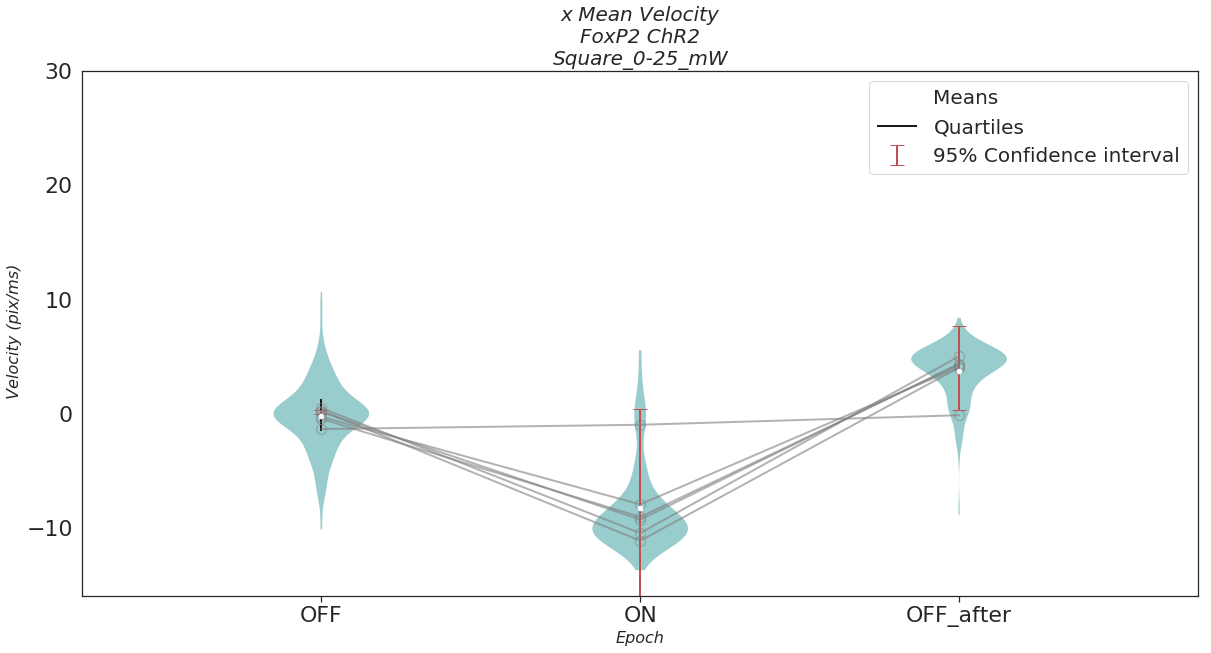

In [30]:
names = ['OFF','ON', 'OFF_after']
measure='Mean' #specify the measure for the ON-Laser Epoch
data_init =min_and_mean_on_off(epochs_all_mice,pre_interval,post_interval,interval,measure)
print('data_init =',data_init.shape)
violin_plot_summary(data_init,names,measure)
# plot_every_mouse_mean(epochs_mean_each_mouse)
plt.show()




# Plot the Pre Laser X Distribution

spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2
spont =n
 number of session = 2 out of 2


<Figure size 432x288 with 0 Axes>

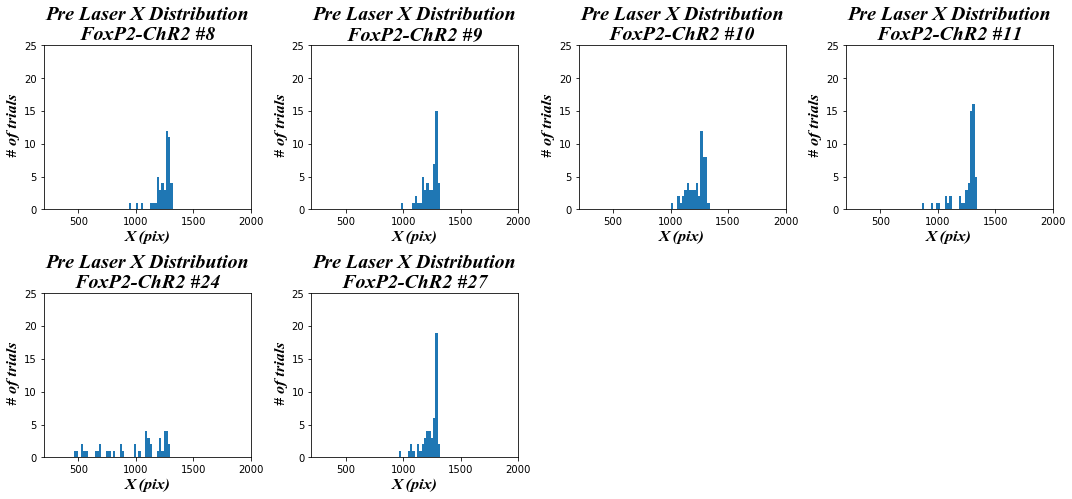

In [200]:
opto_par = 'ChR2'
# opto_par = 'Control'

## 1 mW intensity
folder = 'STR_Square_HI_1';  
# folder = 'STN_Square_HI_1'; #Vglut control folder's name
# folder = 'Square_HI_1';

## 0.5 mW intensity
folder = 'STR_Square_HI';  
# folder = 'STN_Square_HI'; #Vglut control folder's name
# folder = 'Square_HI';
# folder= 'Square_0-5_mW'

## 0.25 mW intensity
folder = 'Square_0-25_mW'

# mouse_type = 'Vglut'
# mouse_type = 'D2';
mouse_type = 'FoxP2'
folder_spont = 'Spontaneous'

pre_stim_inter = 10 # number of timebins in the pre-stimulus period 
# n_bins = 45
plt.figure(2)
fig = plt.figure(figsize=(15,10))
count = 0
min_x =200
max_y = 25 ; max_x = 2000
step = 20
bins_list = np.arange(0,max_x,step)
for n in FoxP2_list[0][:]: # Run over all the mice
    count +=1
    start = timeit.default_timer()
    mouse_no = n
    direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse

    files_list_DLC = list_all_data_files(direct+folder+'/DLC',extension)
    files_list_Laser = list_all_data_files(direct+folder+'/Laser',extension)

    pre_x_position_epochs = extract_pre_laser_x_epochs_over_trials(files_list_DLC,files_list_Laser,folder,'n', pre_stim_inter)
    pre_x_position = np.average(pre_x_position_epochs,axis = 1)
    
    x = fig.add_subplot(3,4,count)
    
    plt.hist(pre_x_position, bins=bins_list)
    plt.ylabel(" # of trials", fontproperties=font_label)
    plt.xlabel("X (pix)", fontproperties=font_label)
    plt.xlim(min_x,max_x) #set limits
    plt.ylim(0,max_y) #set limits
    plt.title("Pre Laser X Distribution"+"\n"+mouse_type+'-'+opto_par+' #'+str(mouse_no) , fontproperties=font)

plt.tight_layout()
plt.savefig(pre_direct+'Subplots'+'/Pre_laser_X_distribution_'+folder+"_"+opto_par+'_'+mouse_type+'_' +
            '.png',bbox_inches='tight',orientation='landscape',dpi=400)
plt.show()




# Plot One mouse

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1


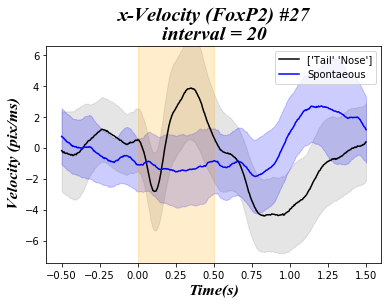

In [106]:

where_plot,which_plot = get_input_cor_body_part() # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user
epochs,epochs_spont = epochs_single_file(file_name_pos,file_name_spont,file_name_laser)
plt.figure(1)
plot_pre_on_post(epochs,epochs_spont,average = 'n')

#a = np.empty((0,2), int)
#for i in range (epochs.shape[1]):
#    m = [sms.DescrStatsW(epochs[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
#    a = np.append(a,[[m[0][0],m[0][1]]],axis=0)


# Blah Blah

In [73]:
a = np.arange(10)

take = np.hstack((np.arange(1,3),np.arange(2,6))) 
print((set(take)))
print(np.take(a, sorted(set(take))))
print(a[take])

{1, 2, 3, 4, 5}
[1 2 3 4 5]
[1 2 2 3 4 5]


In [72]:
#%% 
#################################    Spontaneous vs. Stimulated     #####################################################
################################# Tail/Nose velocity  ###############################################
#
#
####%%%%%%%%%%%%%%%% |||| Choose either Nose or Tail ||||||| %%%%%%%%%%%%%5%%
#param = 'Nose'
##param = 'Tail' 
#
####%%%%%%%%%%%%%%%% |||| Choose either x or y ||||||| %%%%%%%%%%%%%5%%
#cor = 'x'
##cor = 'y' 
###%%%%%%%%%%%%%%%%
#cor_mean_stim =  (df[('r'+param,cor)]+ df[('l'+param,cor)])/2
#velocity = (cor_mean_stim - shift(cor_mean_stim, n_timebin, cval=cor_mean_stim[0]))/ n_timebin
#
#cor_mean_spont =  (df_spont[('r'+param,cor)]+ df_spont[('l'+param,cor)])/2 # average the position of spontaneous position for left and right images
#velocity_spont = (cor_mean_spont - shift(cor_mean_spont, n_timebin, cval=cor_mean_spont[0]))/ n_timebin # velocity derived over n_timebin interval
#time_end = min(len(time_series),len(time_series_spont)) # where to end the plot 
#plt.figure(2)
#plt.plot(time_series[:time_end]+n_timebin/fps, velocity[:time_end], 'navy', linewidth = 0.8, label = 'Stimulated')
#
#plt.axhline(y = 0, color = 'r', linewidth = 0.7) # plot zero velocity threshold
#plt.plot(time_series_spont[:time_end]+n_timebin/fps, velocity_spont[:time_end], 'orange', linewidth = 0.8, label = 'Spontaneous')
#
#plt.ylabel(" Velocity (pix/s)", fontproperties=font_label)
#plt.xlabel("Time(s)", fontproperties=font_label)
#plt.title(param+' ' + cor+ " Velocity ("+ str(n_timebin) +' frame interval) #'+str(mouse_no), fontproperties=font)
#
#min_end = min(min(velocity),min(velocity_spont))
#max_end = max(max(velocity),max(velocity_spont))
#plt.ylim(min_end,max_end) #set limits
#plt.xlim(n_timebin/fps, trial_time_spont/2) # look at half of trial to see better details
#plt.vlines(laser_t['ON']/fps,min_end,max_end, color = 'gray', linewidth = 0.3)# plot stimulus onsets
#plt.legend(fontsize = 10)
#plt.savefig(direct+'/Mouse_trial'+str(trial_no)+'_mouse_' +str(mouse_no)+'_'+ param + '_' + cor+ '_Velociy_' +str(n_timebin)+ '_interval_stim_vs_spont_trial'+str(trial_spont)+'.png',bbox_inches='tight',orientation='landscape',dpi=400)


In [3]:

# General parameters
opto_par = 'ChR2'
# opto_par = 'Control'
trial_no =38 # specify trial number
mouse_no = 8 # specify mouse number
stim_power = 1
trial_spont = 25 
stim_type = 'Square'
# stim_type = 'Square_HI_1'
#############################################
# brain_region = 'STR'
# brain_region_alone = 'STR_alone'
# mouse_type = 'D2'
############################################
brain_region = 'STR';brain_region_alone = 'STN_alone'; mouse_type = 'Vglut'
trial_let = 'b18' # specify trial number
trial_let_spont = 'b_02'
#############################################
brain_region = ''
brain_region_alone = brain_region
mouse_type = 'FoxP2'

# pre_direct = 'C:/Users/P-P1-PNH5/Desktop/Shiva_Behavior/' # folder


#######################################################################################################################################
# files_list = list_all_data_files(direct+'Spontaneous/DLC',extension)

# #################### VGlut 164-165
# file_name_spont = direct+'Spontaneous/DLC/'+mouse_type+str(mouse_no)+ '_' 'spon_act_'+ trial_let_spont+'_DLC.xlsx'
# file_name_laser = direct +brain_region+'_' +stim_type+ '_HI_1'+'/Laser/'+mouse_type+str(mouse_no)+ '_'+brain_region_alone+'_'+str(stim_power)+'mW_square_pulses_'+trial_let+ '_Laser.xlsx' # name of your excel file
# file_name_pos = direct+brain_region+'_' +stim_type+ '_HI_1'+ '/DLC/'+mouse_type+str(mouse_no)+ '_'+brain_region_alone+'_'+str(stim_power)+'mW_square_pulses_'+trial_let+ '_DLC.xlsx' # name of your excel file
# ##################### VGlut  116-119-166
# file_name_spont = direct+'Spontaneous/DLC/Mouse'+str(mouse_no)+'_' + 'spon_act_trial'+ str(trial_spont)+'_DLC.xlsx'
# file_name_laser = direct+brain_region+'_' +stim_type+ '_HI_1'+'/Laser/Mouse'+str(mouse_no)+ '_'+brain_region_alone+'_'+str(stim_power)+'mW_trial' +str(trial_no)+ '_Laser.xlsx' # name of your excel file
# file_name_pos = direct+brain_region+'_' +stim_type+ '_HI_1'+ '/DLC/Mouse'+str(mouse_no)+ '_'+brain_region_alone+'_'+str(stim_power)+'mW_trial' +str(trial_no)+ '_DLC.xlsx' # name of your excel file

# ##################### D2
# file_name_spont = direct+'Spontaneous/DLC/Mouse'+str(mouse_no)+'_' + 'spon_act_trial'+ str(trial_spont)+'_DLC.xlsx'
# file_name_laser = direct+ brain_region+'_' +stim_type+ '_HI_1'+'/Laser/Mouse'+str(mouse_no)+'_'+brain_region_alone+'_'+str(stim_power)+'mW_trial' +str(trial_no)+ '_Laser.xlsx' # name of your excel file
# file_name_pos = direct+ brain_region+'_' +stim_type+ '_HI_1'+'/DLC/Mouse'+str(mouse_no)+'_'+brain_region_alone+'_'+str(stim_power)+'mW_trial' +str(trial_no)+'_DLC.xlsx' # name of your excel file

##################### FoxP2Cre
# file_name_spont = 'Mouse' + mouse_type+ '_#'+str(mouse_no)+'/Spontaneous/DLC/Mouse'+str(mouse_no)+'_' + 'spon_act_trial'+ str(trial_spont)+'_DLC.xlsx'
# file_name_laser = direct+ '/Laser/MouseFoxP2_Cre_#'+str(mouse_no)+ '_'+stim_type+'Pulse_'+str(stim_power)+'mW_' +trial_let+ '_Laser.xlsx' # name of your excel file
# file_name_pos = direct+'_/'+stim_type+ '_HI_1/'+DLC/MouseFoxP2Cre_#'+str(mouse_no)+'_'+stim_type+'Pulse_'+str(stim_power)+'mW_' +trial_let+ '_DLC.xlsx' # name of your excel file



/home/shiva/Behavioral-Analysis
